In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
#from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def fit_and_plot_powerlaw(x, y, ax=None, plot_kwargs=None, fit_kwargs=None):
    x = np.asarray(x)
    y = np.asarray(y)
    n = x.size

    # 1) do the linear fit in log–log
    logx = np.log(x)
    logy = np.log(y)
    # gamma is slope, log(k) is intercept
    gamma, logk = np.polyfit(logx, logy, 1)
    k = np.exp(logk)

    # 2) compute standard error on gamma
    #   residual variance σ² = SSR / (n−2)
    y_fit = gamma*logx + logk
    resid = logy - y_fit
    ssr = np.sum(resid**2)
    sigma2 = ssr / (n - 2)
    #   Sxx = Σ (logx − mean(logx))²
    Sxx = np.sum((logx - logx.mean())**2)
    stderr_gamma = np.sqrt(sigma2 / Sxx)

    # 3) plotting
    if ax is None:
        ax = plt.gca()
    if plot_kwargs is None:
        plot_kwargs = {}
    if fit_kwargs is None:
        fit_kwargs = {"linestyle":"--", "linewidth":2}

    # raw data
    ax.plot(x, y, label="data", **plot_kwargs)
    # fitted power-law
    ax.plot(x, k * x**gamma, label=f"fit: γ={gamma:.3f}±{stderr_gamma:.3f}", **fit_kwargs)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("P", fontsize=14)
    ax.set_ylabel(r"$\lambda^*$", fontsize=14)
    ax.legend()

    return k, gamma, stderr_gamma



In [3]:
def fit_phi(log_x_grid, mean_val_err_arr, P_arr_fit, min_P, x_left, x_right, ax=None):
    """
    Fit y ≈ k * x^(-gamma) on each of the mean‐error curves in double‐log space,
    compute per‐curve slope uncertainties, then average the exponents and prefactors.

    Parameters
    ----------
    log_x_grid : array_like, shape (n_x,)
        The x‐axis values for all curves.
    mean_val_err_arr : array_like, shape (n_P, n_x)
        The mean test‐error curves for each P in P_arr_fit.
    P_arr_fit : array_like, shape (n_P,)
        The list of P values corresponding to the rows of mean_val_err_arr.
    x_left : float or None
        Left cutoff on the *normalized* x‐axis; if None, no left cutoff.
    x_right : float or None
        Right cutoff on the *normalized* x‐axis; if None, no right cutoff.

    Returns
    -------
    gamma_1 : float
        Mean fitted exponent γ across all curves.
    k1      : float
        Mean fitted prefactor k across all curves.
    err_gamma_1 : float
        Standard error on the mean exponent (from the per‐curve fit uncertainties).
    """
    gammas = []
    ks      = []
    sigmas  = []

    for i_P, P in enumerate(P_arr_fit):
        y = mean_val_err_arr[i_P+min_P]
        x = log_x_grid

        # find reference point (where train error ~ 0.25)
        idx   = np.nanargmin(y)
        x_ref = x[idx]
        y_ref = y[idx]

        # normalize both axes
        x_norm = x / x_ref
        y_norm = y / y_ref

        # select the fitting window
        mask = np.isfinite(y_norm)
        if x_left is not None:
            mask &= (x_norm >= x_left)
        if x_right is not None:
            mask &= (x_norm <= x_right)
        # also require positive for log
        mask &= (x_norm > 0) & (y_norm > 0)

        xs = x_norm[mask]
        ys = y_norm[mask]
        log_xs = np.log10(xs)
        log_ys = np.log10(ys)

        # linear regression in log-log; returns coeffs [slope, intercept]
        p, cov = np.polyfit(log_xs, log_ys, 1, cov=True)
        slope, intercept = p
        sigma_slope = np.sqrt(cov[0,0])

        # translate to power‐law params
        gamma_i = -slope
        k_i     = 10**intercept

        gammas.append(gamma_i)
        ks.append(k_i)
        sigmas.append(sigma_slope)

        # overlay the fit as a dashed line on your existing plot
        y_fit = k_i * xs**(-gamma_i)
        if ax==None:
            plt.plot(xs, y_fit, "--", color=colorlist[i_P+min_P])
        else:
            ax.plot(xs, y_fit, "--", color=colorlist[i_P+min_P])

    gammas = np.array(gammas)
    ks      = np.array(ks)
    sigmas  = np.array(sigmas)

    # mean exponent and prefactor
    gamma_1 = gammas.mean()
    k1      = ks.mean()
    # standard error on the mean exponent
    err_gamma_1 = np.sqrt((sigmas**2/len(sigmas)).sum())

    return gamma_1, k1, err_gamma_1


# CNN with one difference

## Norms C10

/tmp/ipykernel_7679/1827736451.py:43: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


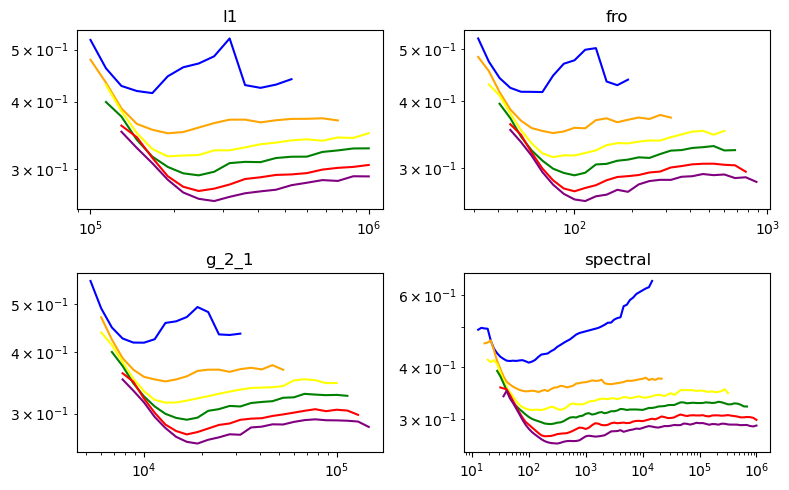

In [5]:
dataset = "CIFAR10"
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,20)
wd=0.0

norms_name = np.array(["l1","fro","g_2_1","spectral"])

#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.5, 6, num=100)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(norms_name), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

fig, axs = plt.subplots(2,2, figsize=(8,5))

for i_norm, norm in enumerate(norms_name):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_norm, i_P] = mean_val_error
    
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")


#plt.set_xlabel(r"$\lambda(t)$", fontsize=14)
#plt.set_ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title(dataset)
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.25,0.8))
fig.tight_layout()
plt.show()

/tmp/ipykernel_7679/70269634.py:29: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


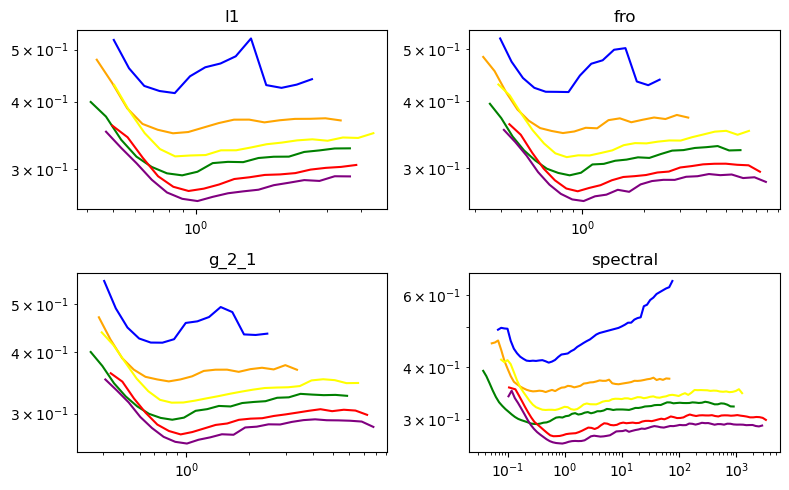

In [6]:
# Store interpolated results here
mean_curves = {}

fig, axs = plt.subplots(2,2, figsize=(8,5))
l_0_arr = np.zeros((len(norms_name),len(P_arr)))
for i_norm, norm in enumerate(norms_name):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_norm, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}")
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")
        
#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title(dataset)
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
fig.tight_layout()
plt.show()

0
1
2
3


/tmp/ipykernel_7679/2820522348.py:35: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


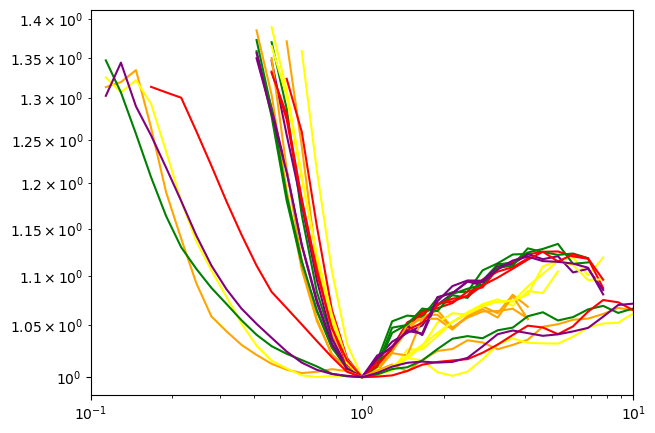

In [7]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([None, None, None, None])
#x_right_arr = np.array([9.5e-1,7e-1, 7e-1,7e-1])
x_right_arr = np.array([None, None, None, None])

gamma_1_arr = np.zeros(len(norms_name))
err_gamma_1_arr = np.zeros(len(norms_name))

plt.figure(figsize=(7,5))

for i_norm, norm in enumerate(norms_name):
    print(i_norm)
    for i_P, P in enumerate(P_arr_fit):
        
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}")
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")

        #print(P)

    
    x_left = x_left_arr[i_norm]
    x_right = x_right_arr[i_norm]
    #gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_norm], P_arr_fit, min_P, x_left, x_right, ax=None)
    #gamma_1_arr[i_norm] = gamma_1
    #err_gamma_1_arr[i_norm] = err_gamma_1

plt.yscale("log")
plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.97,1.8))
plt.xlim((0.1,10))
fig.tight_layout()
plt.show()

0
1
2
3


/tmp/ipykernel_7679/3680654804.py:34: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


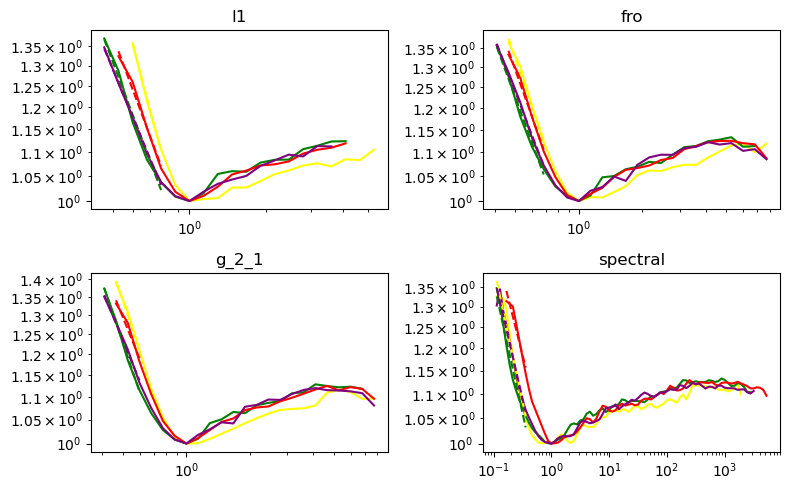

In [37]:
# Store interpolated results here
min_P = 2
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([None, None, None, None])
x_right_arr = np.array([8e-1,7e-1, 6e-1,4e-1])

gamma_1_arr = np.zeros(len(norms_name))
err_gamma_1_arr = np.zeros(len(norms_name))

fig, axs = plt.subplots(2,2, figsize=(8,5))

for i_norm, norm in enumerate(norms_name):
    print(i_norm)
    for i_P, P in enumerate(P_arr_fit):
        
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved[norm])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_norm].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}")
        axs.flatten()[i_norm].set_title(norm)
        axs.flatten()[i_norm].set_xscale("log")
        axs.flatten()[i_norm].set_yscale("log")

    x_left = x_left_arr[i_norm]
    x_right = x_right_arr[i_norm]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_norm], P_arr_fit, min_P, x_left, x_right, ax= axs.flatten()[i_norm])
    gamma_1_arr[i_norm] = gamma_1
    err_gamma_1_arr[i_norm] = err_gamma_1

#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.97,1.8))
fig.tight_layout()
plt.show()

In [38]:
print(gamma_1_arr[0],gamma_1_arr[1],gamma_1_arr[2],gamma_1_arr[3])
print(err_gamma_1_arr[0],err_gamma_1_arr[1],err_gamma_1_arr[2],err_gamma_1_arr[3])

0.6178890176096723 0.49498245218139425 0.5026751089601509 0.21018816972409848
0.036524906335480715 0.02945500236622957 0.052471109272977226 0.016985350983560302


Fitted power law wd=0.0: k2 = 1.974e+04, gamma2 = 0.2458
Fitted power law wd=0.0: k2 = 9.611, gamma2 = 0.2293
Fitted power law wd=0.0: k2 = 1166, gamma2 = 0.2601
Fitted power law wd=0.0: k2 = 72.41, gamma2 = 0.157


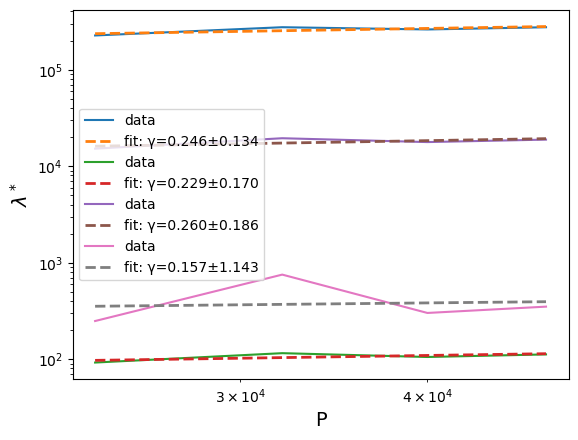

In [39]:
gamma_2_arr = np.zeros(len(norms_name))
err_gamma_2_arr = np.zeros(len(norms_name))

for i_norm, norm in enumerate(norms_name):
    l_power_law = l_0_arr[i_norm, min_P:]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_norm] = gamma_2
    err_gamma_2_arr[i_norm] = err_gamma_2

In [40]:
for i_norm, norm in enumerate(norms_name):
    gamma_1 = gamma_1_arr[i_norm]
    gamma_2 = gamma_2_arr[i_norm]
    print("Norm=", norm," gamma_pred=", gamma_1*gamma_2)

Norm= l1  gamma_pred= 0.151884319666829
Norm= fro  gamma_pred= 0.11349274078089241
Norm= g_2_1  gamma_pred= 0.13076442551794126
Norm= spectral  gamma_pred= 0.033008147184374524


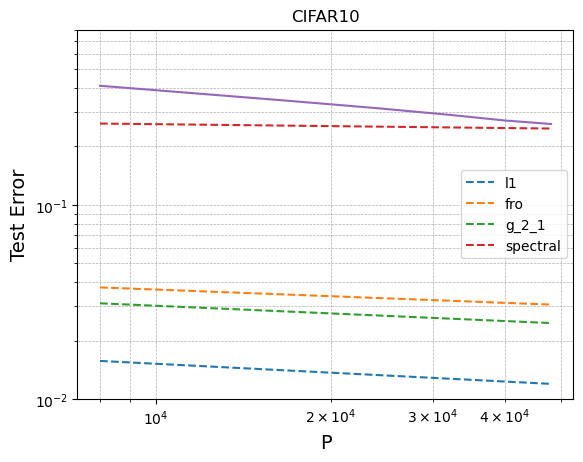

In [41]:
colors = np.array(["blue","red","green"])

for i_norm, norm in enumerate(norms_name):
    eps_lam_star_P_arr = np.zeros(len(P_arr))
    
    lambda_star_arr = np.zeros(len(P_arr))

    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_norm,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_norm,i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]
    
    plt.plot(P_arr, k1*(k2*P_arr**gamma_2_arr[i_norm])**-gamma_1_arr[i_norm], "--", label=norm)
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.plot(P_arr, eps_lam_star_P_arr)

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((1e-2,0.8))
plt.show()

## SGD C10

/tmp/ipykernel_7679/533148043.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


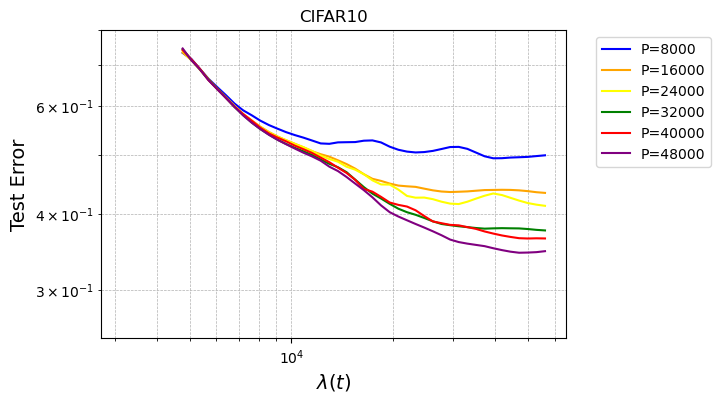

In [50]:
dataset = "CIFAR10"
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,18)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(3.5, 4.75, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_SGD.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])


gamma_1_a = 0.39
k1_a = 79.
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.34
k1_b = 43.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.25,0.8))
plt.show()

/tmp/ipykernel_7679/2100907112.py:29: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


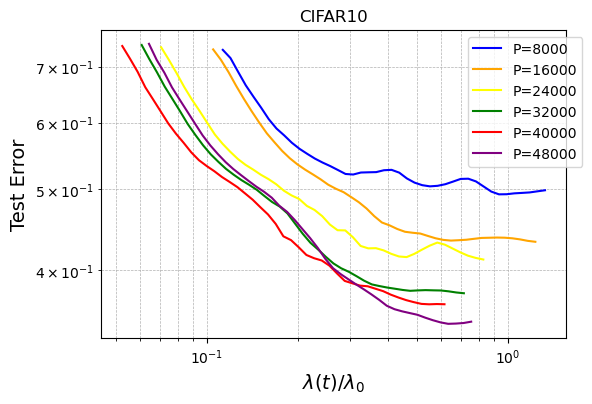

In [54]:
# Store interpolated results here
mean_curves = {}

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_SGD.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_7679/4202629762.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


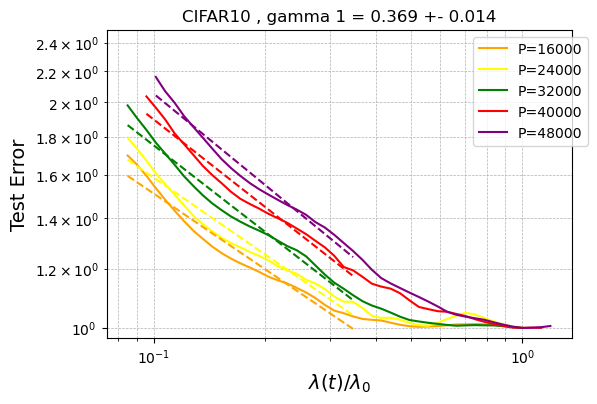

In [62]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_SGD.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 3.5e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,2.5))
plt.show()

Fitted power law: k2 = 334.1, gamma2 = 0.5184


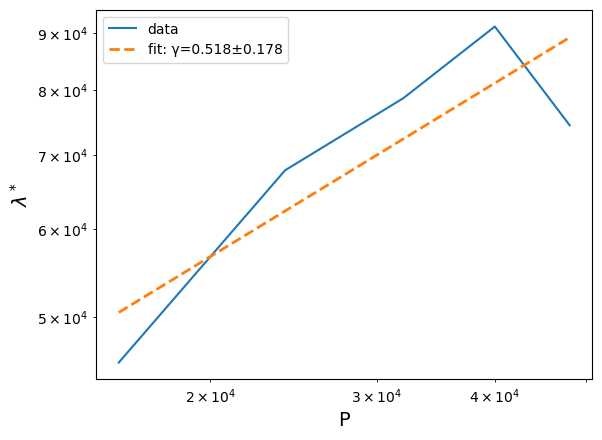

In [63]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [ ]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

In [64]:
print(gamma_1*gamma_2)

0.1911176910482169


/tmp/ipykernel_7679/2410265685.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


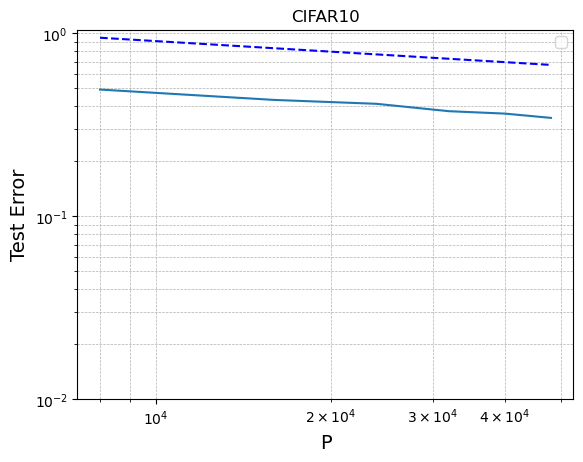

In [66]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 60*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.05))
plt.show()

In [13]:
name_save = "CNN_CIFAR10"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2

to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## SGD C100

/tmp/ipykernel_7679/1204319799.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


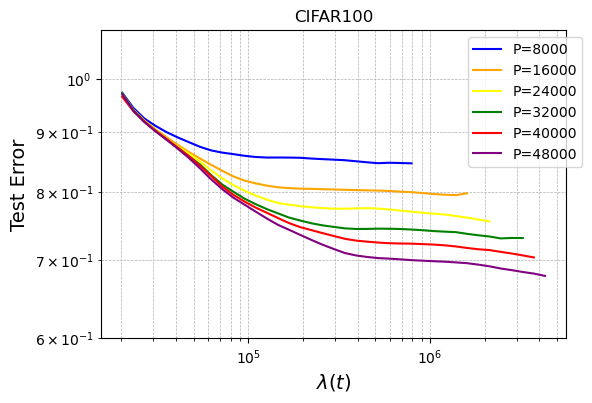

In [70]:
dataset = "CIFAR100"
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,18)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(4, 7, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_SGD.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])



plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.6,1.1))
plt.show()

/tmp/ipykernel_7679/2100907112.py:29: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


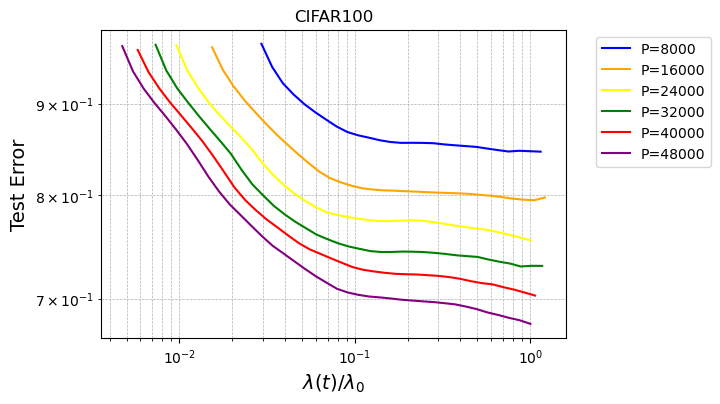

In [71]:
# Store interpolated results here
mean_curves = {}

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_SGD.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_7679/337384120.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


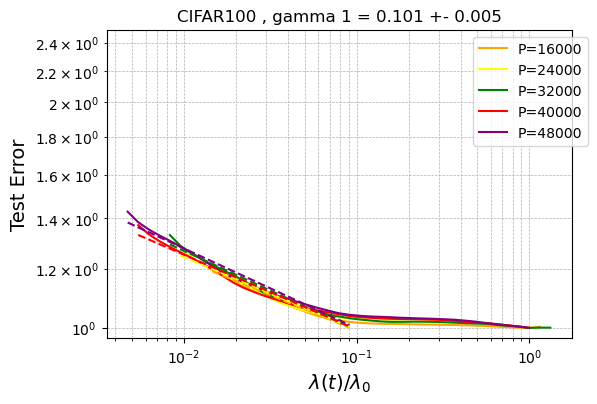

In [72]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_SGD.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 1e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,2.5))
plt.show()

Fitted power law: k2 = 46.31, gamma2 = 1.061
0.1068177885799365


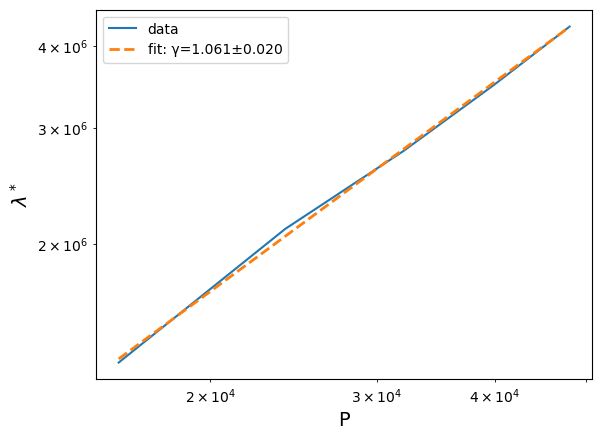

In [73]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
print(gamma_1*gamma_2)

/tmp/ipykernel_7679/3844719609.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


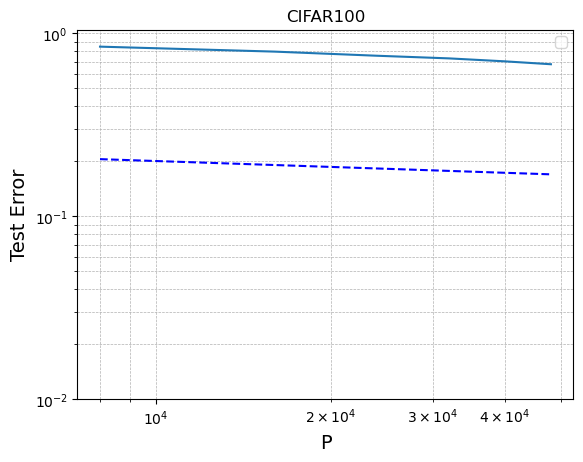

In [74]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 1*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.05))
plt.show()

## WD  C10

/tmp/ipykernel_7679/2976077397.py:40: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


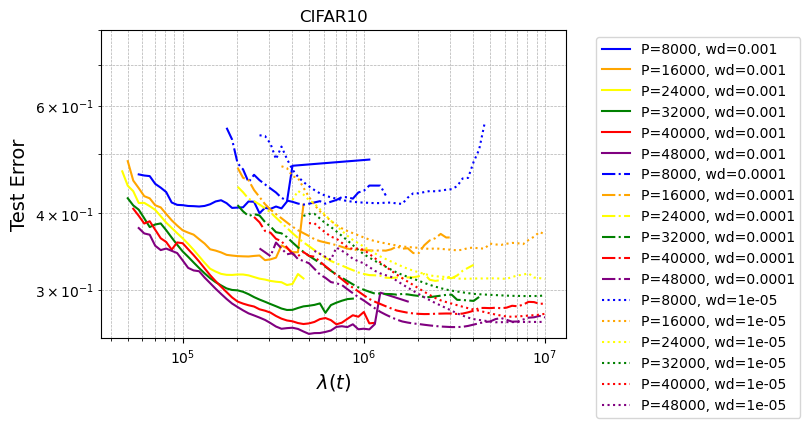

In [77]:
dataset = "CIFAR10"
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,20)
wd_arr = np.array([0.001,0.0001, 0.00001])
#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(4, 7, num=100)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(wd_arr), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_wd, i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid, mean_val_error, label=f"P={P}, wd={wd}", color=colorlist[i_P],  linestyle=line_styles[i_wd])

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.25,0.8))
plt.show()

/tmp/ipykernel_7679/3467074029.py:30: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


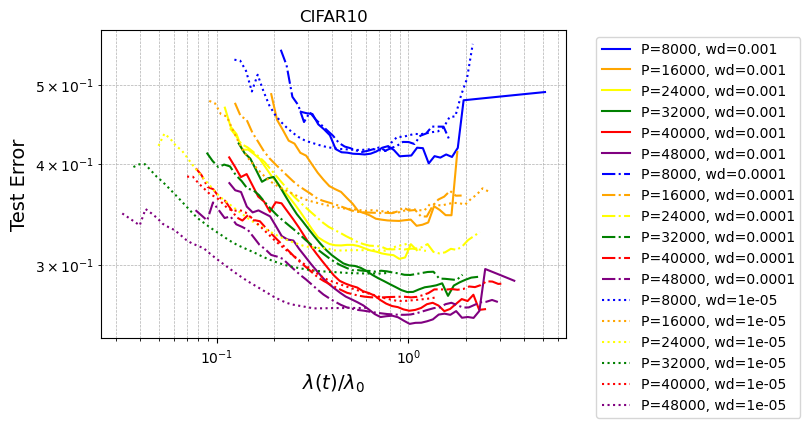

In [78]:
# Store interpolated results here
mean_curves = {}


plt.figure(figsize=(6,4))
l_0_arr = np.zeros((len(wd_arr),len(P_arr)))
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_wd, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}, wd={wd}", linestyle=line_styles[i_wd])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_7679/1347364591.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


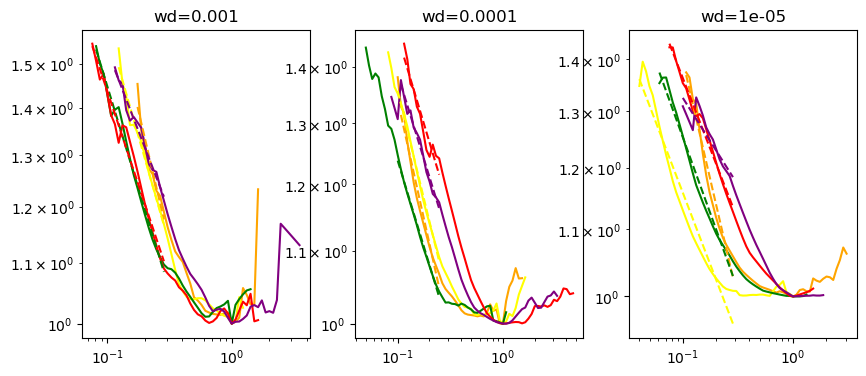

In [90]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([None, 1e-1, None])
x_right_arr = np.array([3e-1,2.5e-1, 3e-1])

gamma_1_arr = np.zeros(len(wd_arr))
err_gamma_1_arr = np.zeros(len(wd_arr))

fig, axs = plt.subplots(1,3, figsize=(10,4))
    
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr_fit):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])
            val_error = np.array(logs_saved["val_error"])*0.01
            train_error =np.array(logs_saved["train_error"])*0.01 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_wd].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}, wd={wd}")
        axs.flatten()[i_wd].set_title(f"wd={wd}")
        axs.flatten()[i_wd].set_xscale("log")
        axs.flatten()[i_wd].set_yscale("log")

    
    x_left = x_left_arr[i_wd]
    x_right = x_right_arr[i_wd]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_wd], P_arr_fit, min_P, x_left, x_right,  ax= axs.flatten()[i_wd])
    gamma_1_arr[i_wd] = gamma_1
    err_gamma_1_arr[i_wd] = err_gamma_1

#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.97,1.8))
plt.show()

In [91]:
print(gamma_1_arr[0],gamma_1_arr[1],gamma_1_arr[2])
print(err_gamma_1_arr[0],err_gamma_1_arr[1],err_gamma_1_arr[2])

0.2800312129723142 0.22141207659457054 0.18827905087053948
0.022083954650828422 0.010913969138044783 0.009938081477936955


Fitted power law wd=0.001: k2 = 1740, gamma2 = 0.5259
Fitted power law wd=0.0001: k2 = 987.5, gamma2 = 0.7536
Fitted power law wd=1e-05: k2 = 153.6, gamma2 = 1.061


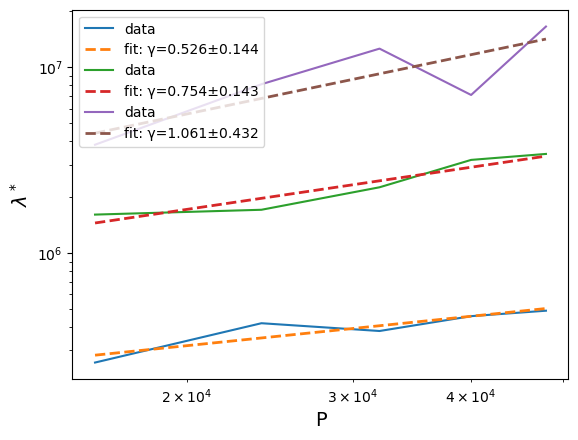

In [92]:
gamma_2_arr = np.zeros(len(wd_arr))
err_gamma_2_arr = np.zeros(len(wd_arr))

for i_wd, wd in enumerate(wd_arr):
    l_power_law = l_0_arr[i_wd, min_P:]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_wd] = gamma_2
    err_gamma_2_arr[i_wd] = err_gamma_2

In [93]:
for i_wd, wd in enumerate(wd_arr):
    gamma_1 = gamma_1_arr[i_wd]
    gamma_2 = gamma_2_arr[i_wd]
    print("wd=", wd," gamma_pred=", gamma_1*gamma_2)

wd= 0.001  gamma_pred= 0.14728150483076646
wd= 0.0001  gamma_pred= 0.16684745982332533
wd= 1e-05  gamma_pred= 0.19971022527947388


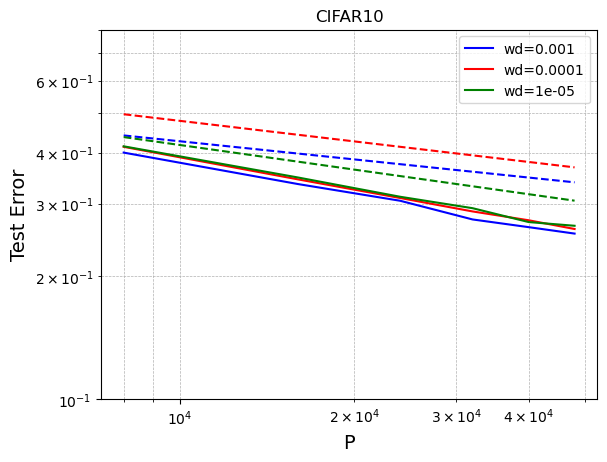

In [94]:
colors = np.array(["blue","red","green"])
for i_wd, wd in enumerate(wd_arr):
    eps_lam_star_P_arr = np.zeros(len(P_arr))
    
    lambda_star_arr = np.zeros(len(P_arr))
    
    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_wd,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_wd,i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]
    
    plt.plot(P_arr, eps_lam_star_P_arr, color=colors[i_wd], label=f"wd={wd}")
    
    plt.plot(P_arr, 8*k1*(k2*P_arr**gamma_2_arr[i_wd])**-gamma_1_arr[i_wd], "--", color=colors[i_wd])
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((1e-1,0.8))
plt.show()

## WD C100

/tmp/ipykernel_7679/299426134.py:40: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


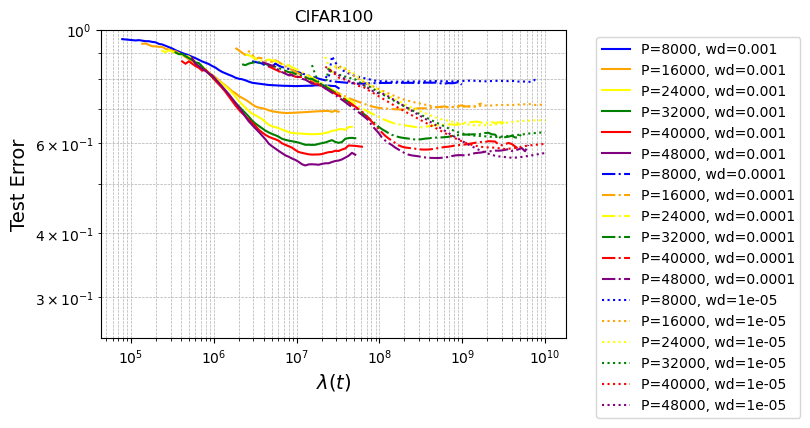

In [153]:
dataset = "CIFAR100"
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,20)
wd_arr = np.array([0.001,0.0001,0.00001])
#wd_names = np.array(["1_2","1_3","1_4","1_5"])

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
line_styles = ['-', '-.', ':', '--']

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2, 10, num=200)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(wd_arr), len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])[:-20]
            val_error = (np.array(logs_saved["val_error"])*0.01)[:-20]
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_val_error_arr[i_wd, i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid, mean_val_error, label=f"P={P}, wd={wd}", color=colorlist[i_P],  linestyle=line_styles[i_wd])

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.25,1.0))
plt.show()

/tmp/ipykernel_7679/3771773075.py:30: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


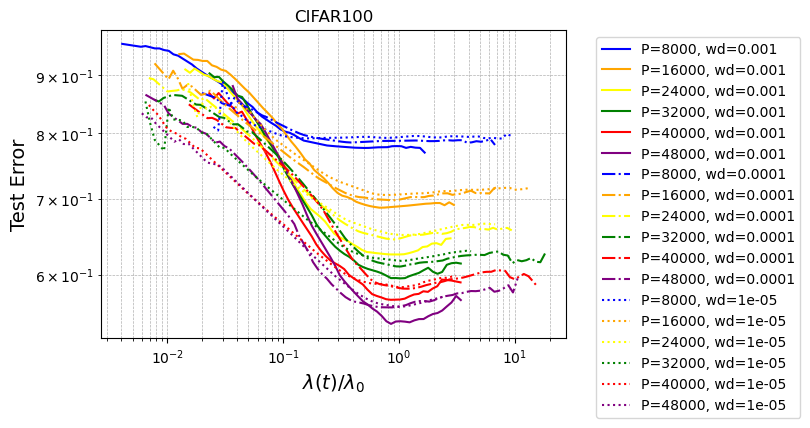

In [154]:
# Store interpolated results here
mean_curves = {}


plt.figure(figsize=(6,4))
l_0_arr = np.zeros((len(wd_arr),len(P_arr)))
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])[:-20]
            val_error = (np.array(logs_saved["val_error"])*0.01)[:-20]
            train_error =(np.array(logs_saved["train_error"])*0.01)[:-20] 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
            idx_zero  = np.argmin((val_error)**2)
            where_zero = model_norm[idx_zero]
            w_z += where_zero/(len(seed_arr))
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
        l_0_arr[i_wd, i_P] = w_z
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        mean_curves[i_P] = mean_val_error
    
        # Plot the mean curve
        plt.plot(log_x_grid/w_z, mean_val_error,
                 color=colorlist[i_P], label=f"P={P}, wd={wd}", linestyle=line_styles[i_wd])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_7679/3347496846.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


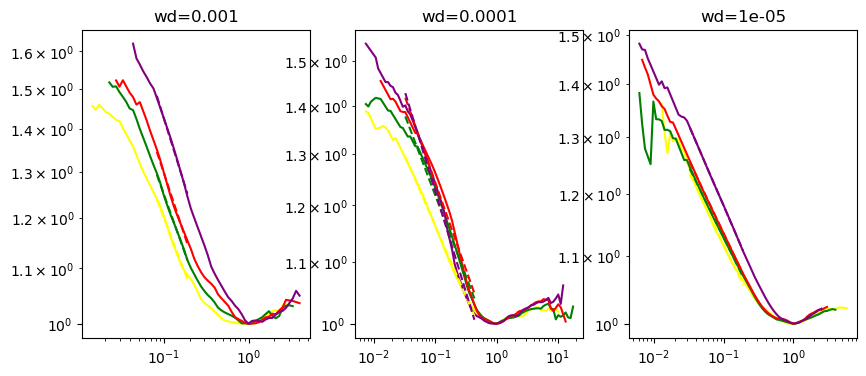

In [155]:
# Store interpolated results here
min_P = 2
P_arr_fit = P_arr[min_P:]

mean_curves = {}

x_left_arr = np.array([8e-2, 3e-2, 3e-2])
x_right_arr = np.array([2e-1,4.5e-1, 2e-1])

gamma_1_arr = np.zeros(len(wd_arr))
err_gamma_1_arr = np.zeros(len(wd_arr))

fig, axs = plt.subplots(1,3, figsize=(10,4))
    
for i_wd, wd in enumerate(wd_arr):
    for i_P, P in enumerate(P_arr_fit):
        interpolated_val_errors = []
        w_z = 0
        
        for seed in seed_arr:
            logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_ALLNORM.npy", allow_pickle=True).item()
            model_norm = np.array(logs_saved["model_norm"])[:-20]
            val_error = (np.array(logs_saved["val_error"])*0.01)[:-20]
            train_error =(np.array(logs_saved["train_error"])*0.01)[:-20] 
    
            # Interpolation: flat in log-scale, thus interpolate on log(x)
            interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
            interpolated_val_errors.append(interp_val_error)
    
        interpolated_val_errors = np.array(interpolated_val_errors)
        
        mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
        
        idx = np.nanargmin(mean_val_error)
        # Plot the mean curve
        axs.flatten()[i_wd].plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
                 color=colorlist[i_P+min_P], label=f"P={P}, wd={wd}")
        axs.flatten()[i_wd].set_title(f"wd={wd}")
        axs.flatten()[i_wd].set_xscale("log")
        axs.flatten()[i_wd].set_yscale("log")

    
    x_left = x_left_arr[i_wd]
    x_right = x_right_arr[i_wd]
    gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr[i_wd], P_arr_fit, min_P, x_left, x_right,  ax= axs.flatten()[i_wd])
    gamma_1_arr[i_wd] = gamma_1
    err_gamma_1_arr[i_wd] = err_gamma_1

#plt.yscale("log")
#plt.xscale("log")
#plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
#plt.ylabel("Test Error", fontsize=14)
#plt.legend(bbox_to_anchor=(1.05,1.0))
#plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
#plt.grid(True, which="both", linestyle="--", linewidth=0.5)
#plt.ylim((0.97,1.8))
plt.show()

In [156]:
print(gamma_1_arr[0],gamma_1_arr[1],gamma_1_arr[2])
print(err_gamma_1_arr[0],err_gamma_1_arr[1],err_gamma_1_arr[2])

0.18385501645414173 0.11352697096100192 0.09050420324507716
0.003991741021308867 0.0024871028875521582 0.0007068187410021917


Fitted power law wd=0.001: k2 = 2.987e+07, gamma2 = -0.05905
Fitted power law wd=0.0001: k2 = 5.474e+05, gamma2 = 0.6219
Fitted power law wd=1e-05: k2 = 613.6, gamma2 = 1.459


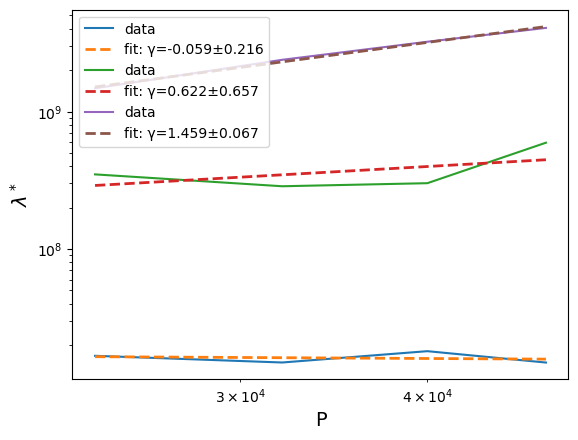

In [157]:
gamma_2_arr = np.zeros(len(wd_arr))
err_gamma_2_arr = np.zeros(len(wd_arr))

for i_wd, wd in enumerate(wd_arr):
    l_power_law = l_0_arr[i_wd, min_P:]
    k2, gamma_2,err_gamma_2  = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
    print(f"Fitted power law wd={wd}: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
    gamma_2_arr[i_wd] = gamma_2
    err_gamma_2_arr[i_wd] = err_gamma_2

In [148]:
for i_wd, wd in enumerate(wd_arr):
    gamma_1 = gamma_1_arr[i_wd]
    gamma_2 = gamma_2_arr[i_wd]
    print("wd=", wd," gamma_pred=", gamma_1*gamma_2)

wd= 0.001  gamma_pred= -0.010851642989760152
wd= 0.0001  gamma_pred= 0.0697287768049163
wd= 1e-05  gamma_pred= 0.13246966910893987


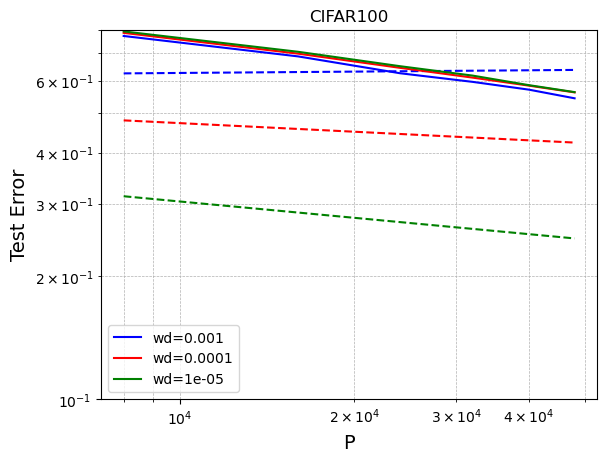

In [149]:
colors = np.array(["blue","red","green"])
for i_wd, wd in enumerate(wd_arr):
    eps_lam_star_P_arr = np.zeros(len(P_arr))
    
    lambda_star_arr = np.zeros(len(P_arr))
    
    for i_P,P in enumerate(P_arr):
         idx = np.nanargmin(mean_val_error_arr[i_wd,i_P])
         #idx = ((log_x_grid-l_power_law[i_P])**2) 
         eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_wd,i_P,idx]
         lambda_star_arr[i_P] = log_x_grid[idx]
    
    plt.plot(P_arr, eps_lam_star_P_arr, color=colors[i_wd], label=f"wd={wd}")
    
    plt.plot(P_arr, 2*k1*(k2*P_arr**gamma_2_arr[i_wd])**-gamma_1_arr[i_wd], "--", color=colors[i_wd])
    #plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((1e-1,0.8))
plt.show()

# ResNet LONG

## CIFAR10

/tmp/ipykernel_8818/253960636.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


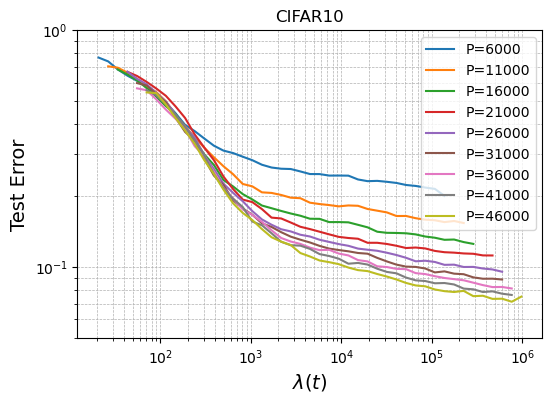

In [50]:
dataset = "CIFAR10"
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(880,888)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(1, 6.2, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")
'''
gamma_1_a = 0.615
k1_a = 17.5
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.58
k1_b = 16.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
'''
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.05,1.))
plt.show()

/tmp/ipykernel_8818/654383052.py:31: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


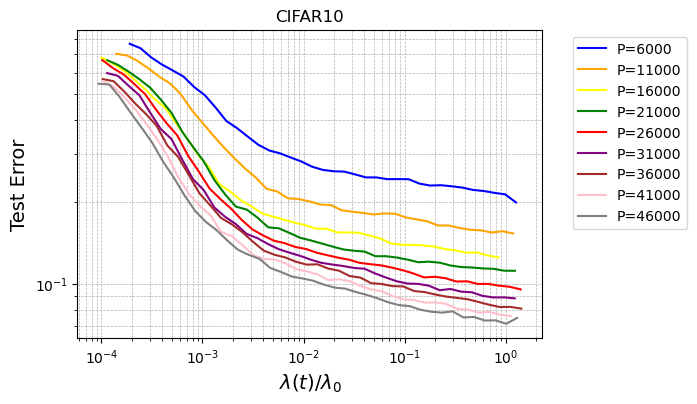

In [25]:
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_8818/1574915661.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


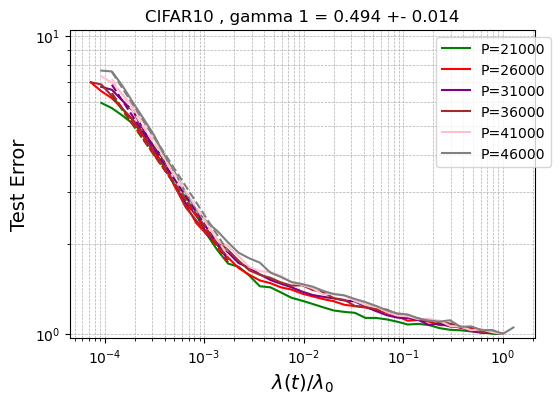

In [26]:
# Store interpolated results here
min_P = 3
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 1e-4
x_right = 2e-3
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,10.5))
plt.show()

In [13]:
factor = 1.

Fitted power law: k2 = 51.89, gamma2 = 0.8882


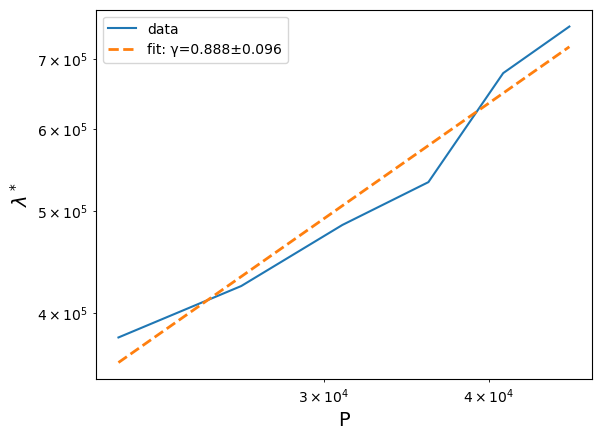

In [27]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [ ]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

In [ ]:
gamma_1 = (gamma_1_a+gamma_1_b)/2
k1 = (k1_a+k1_b)/2
print(gamma_1*gamma_2)

/tmp/ipykernel_8818/2069843730.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


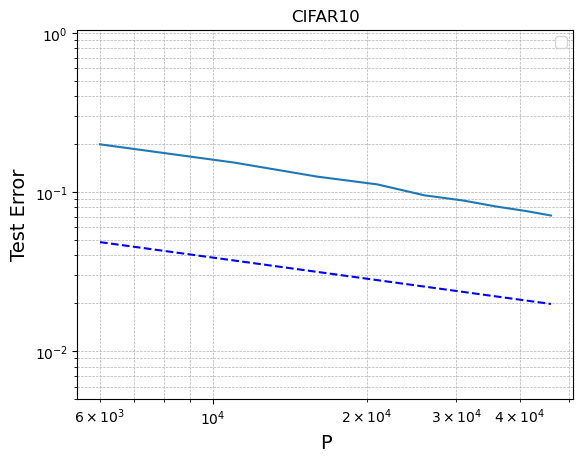

In [28]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr,  200*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((5e-3,1.05))
plt.show()

In [30]:
name_save = "ResNet_CIFAR10_rebuttal"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## CIFAR100

/tmp/ipykernel_30370/725109963.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


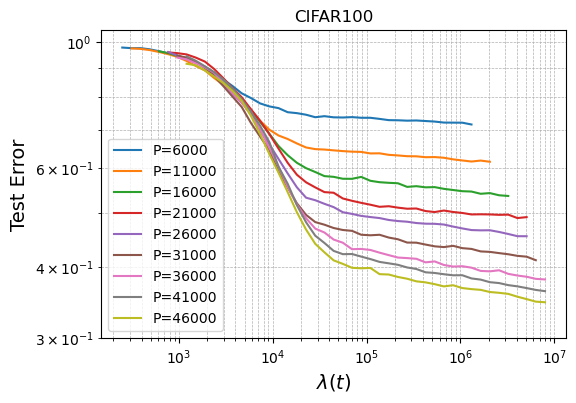

In [11]:
dataset = "CIFAR100"
P_arr = np.arange(6000, 46001, 5000)
seed_arr = np.arange(880,885) 

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2.2, 7, num=50)  # Adjust range and number of points as needed

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD0.0.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

'''
gamma_1_a = 0.415
k1_a = 37.4
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.33
k1_b = 17
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
'''
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.3,1.05))
plt.show()

/tmp/ipykernel_8818/3453016239.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


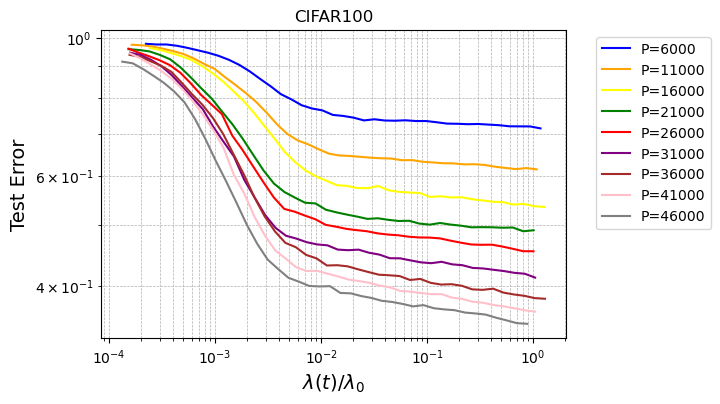

In [33]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_8818/591901010.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


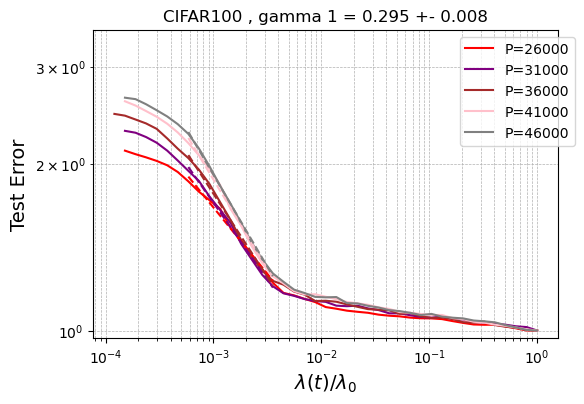

In [39]:
# Store interpolated results here
min_P = 4
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 5e-4
x_right = 4e-3
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,3.5))
plt.show()

In [40]:
factor = 1

Fitted power law: k2 = 262.5, gamma2 = 0.9686


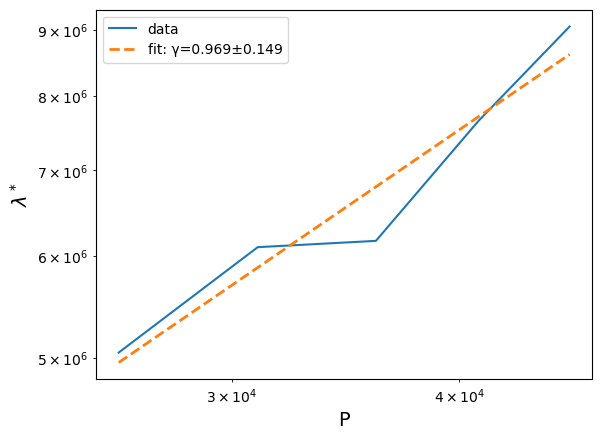

In [41]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [ ]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

In [ ]:
gamma_1 = (gamma_1_a+gamma_1_b)/2
k1 = (k1_a+k1_b)/2
print(gamma_1*gamma_2)

/tmp/ipykernel_8818/1922478856.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


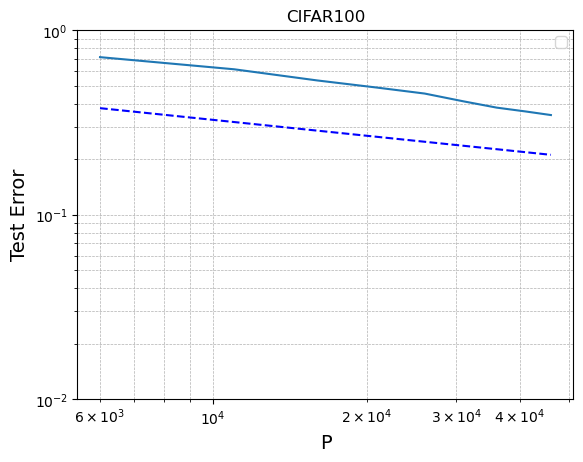

In [42]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 100*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

In [43]:
name_save = "ResNet_CIFAR100_rebuttal"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P


np.save(name_save, to_save)

# ResNet scaled down

## CIFAR 10

/tmp/ipykernel_98704/2414132129.py:38: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


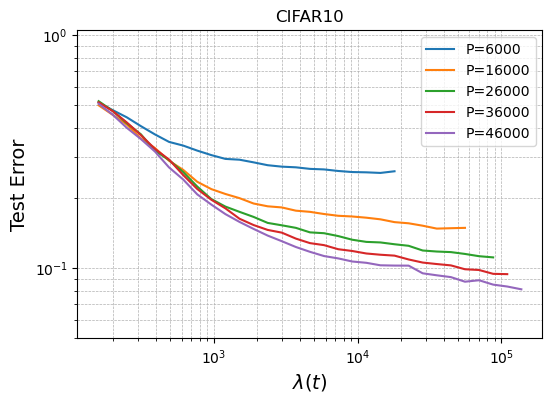

In [7]:
dataset = "CIFAR10"
P_arr = np.arange(6000, 46001, 10000)
seed_arr = np.arange(10,20) 


colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2.2, 7, num=50)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))


to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD0.0_SCALED.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

'''
gamma_1_a = 0.415
k1_a = 37.4
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.33
k1_b = 17
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
'''
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.05,1.05))
plt.show()

/tmp/ipykernel_98704/1582290769.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


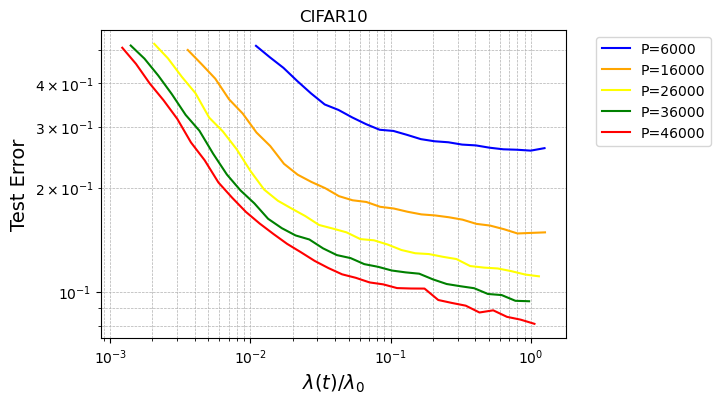

In [8]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_SCALED.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_98704/2288210862.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


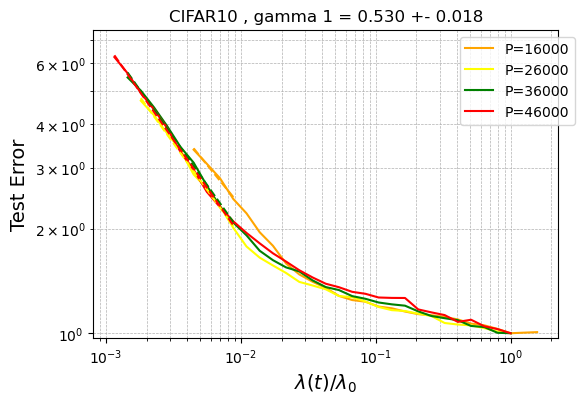

In [9]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_SCALED.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 1e-2
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,7.5))
plt.show()

Fitted power law: k2 = 1.773, gamma2 = 1.049


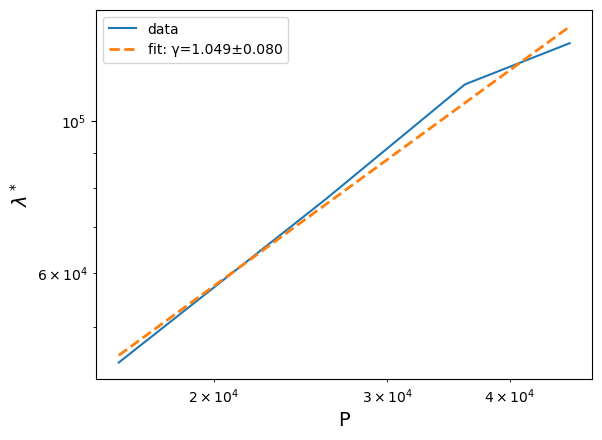

In [10]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [11]:
print(gamma_1*gamma_2)

0.5561234109333308


/tmp/ipykernel_98704/1922478856.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


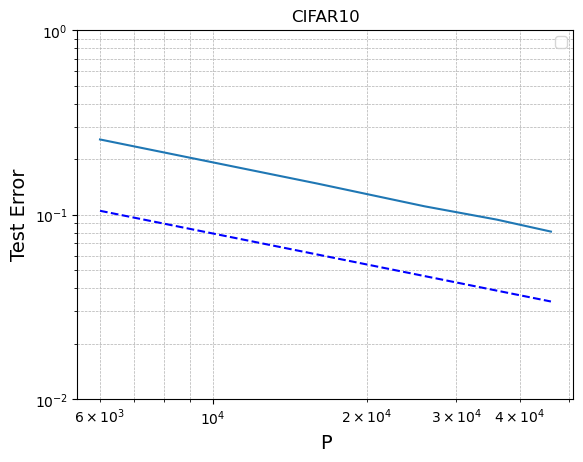

In [13]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 100*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

## CIFAR100

/tmp/ipykernel_98704/483791581.py:38: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


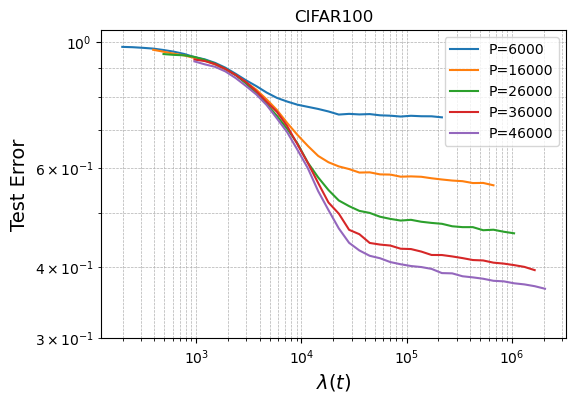

In [26]:
dataset = "CIFAR100"
P_arr = np.arange(6000, 46001, 10000)
seed_arr = np.arange(10,20) 


colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2.2, 7, num=50)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))


to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD0.0_SCALED.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

'''
gamma_1_a = 0.415
k1_a = 37.4
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.33
k1_b = 17
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
'''
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.3,1.05))
plt.show()

/tmp/ipykernel_98704/1582290769.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


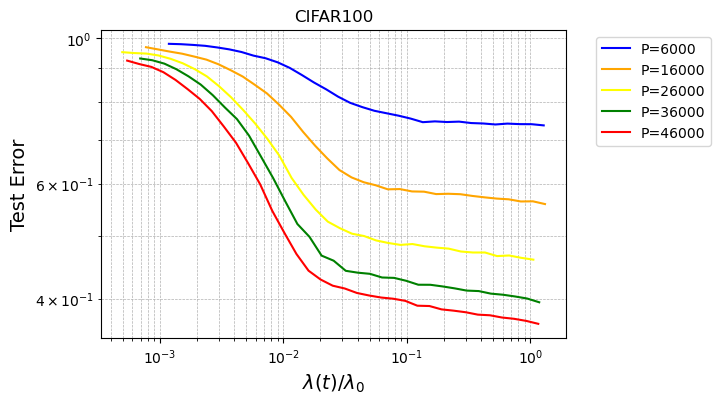

In [17]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_SCALED.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_98704/937545977.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


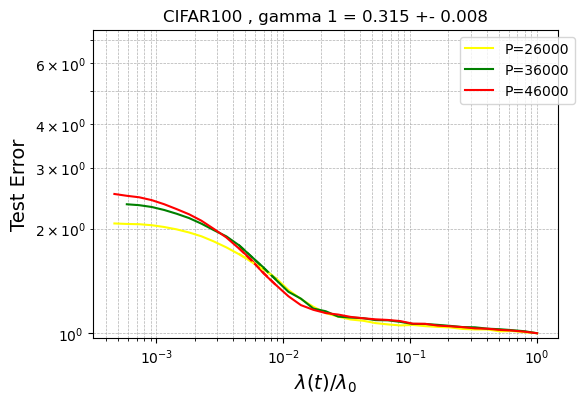

In [22]:
# Store interpolated results here
min_P = 2
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_SCALED.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 4e-3
x_right = 1e-2
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,7.5))
plt.show()

Fitted power law: k2 = 28.82, gamma2 = 1.027


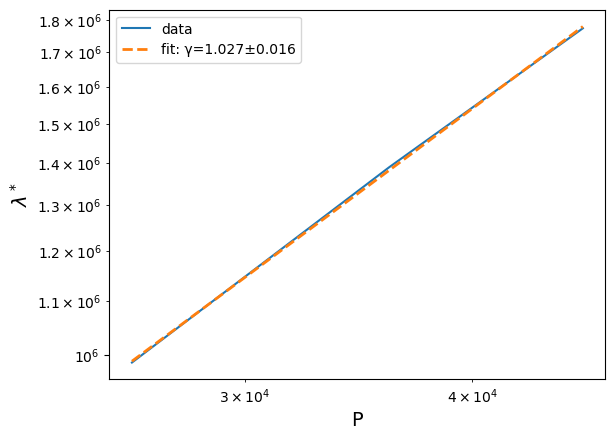

In [23]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [24]:
print(gamma_1*gamma_2)

0.32358277613645875


/tmp/ipykernel_98704/3141670751.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


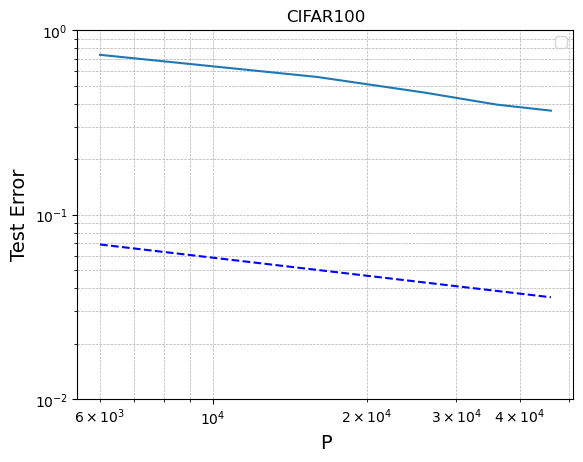

In [25]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 10*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

# VS Time

/tmp/ipykernel_98704/2388271205.py:29: RuntimeWarning: divide by zero encountered in log10
  interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
/tmp/ipykernel_98704/2388271205.py:35: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


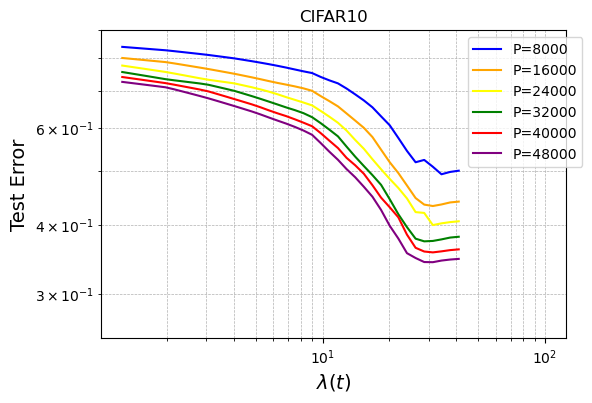

In [30]:
dataset = "CIFAR10"
P_arr = np.arange(8000, 48001, 8000)
seed_arr = np.arange(10,18)
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.1, 2., num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_SGD.npy", allow_pickle=True).item()
        model_norm = np.arange(len(logs_saved["val_error"]))
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])


gamma_1_a = 0.39
k1_a = 79.
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.34
k1_b = 43.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.25,0.9))
plt.show()

/tmp/ipykernel_98704/3125118425.py:29: RuntimeWarning: divide by zero encountered in log10
  interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
/tmp/ipykernel_98704/3125118425.py:35: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


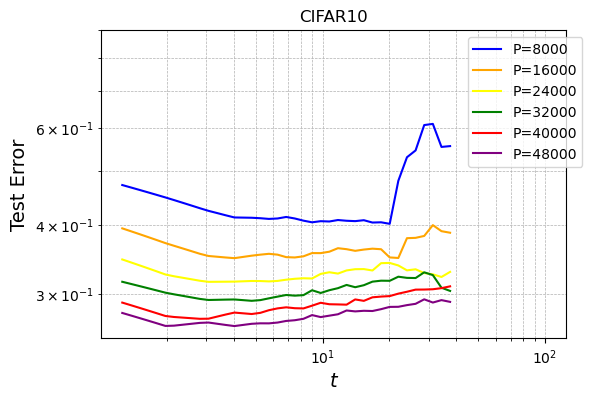

In [31]:
dataset = "CIFAR10"
P_arr = np.arange(8000, 48001, 8000)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.1, 2., num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{0.00001}_ALLNORM.npy", allow_pickle=True).item()
        model_norm = np.arange(len(logs_saved["val_error"]))
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])


gamma_1_a = 0.39
k1_a = 79.
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.34
k1_b = 43.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$t$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.25,0.9))
plt.show()

/tmp/ipykernel_98704/2702553950.py:29: RuntimeWarning: divide by zero encountered in log10
  interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
/tmp/ipykernel_98704/2702553950.py:35: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


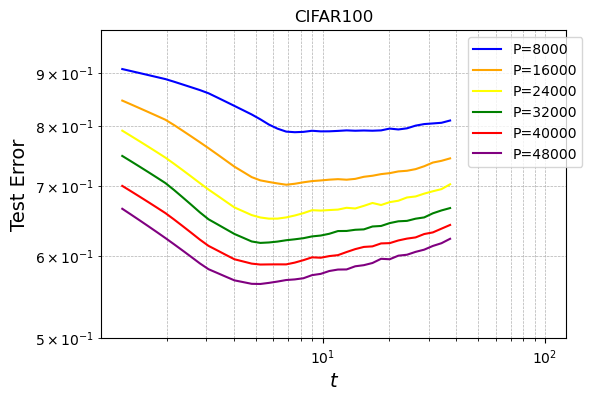

In [32]:
dataset = "CIFAR100"
P_arr = np.arange(8000, 48001, 8000)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.1, 2., num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.ones((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{0.00001}_ALLNORM.npy", allow_pickle=True).item()
        model_norm = np.arange(len(logs_saved["val_error"]))
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}", color=colorlist[i_P])


gamma_1_a = 0.39
k1_a = 79.
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.34
k1_b = 43.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$t$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.5,0.99))
plt.show()

# EARLY MNIST WITH BIG P

## CNN

/tmp/ipykernel_240821/4128197901.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


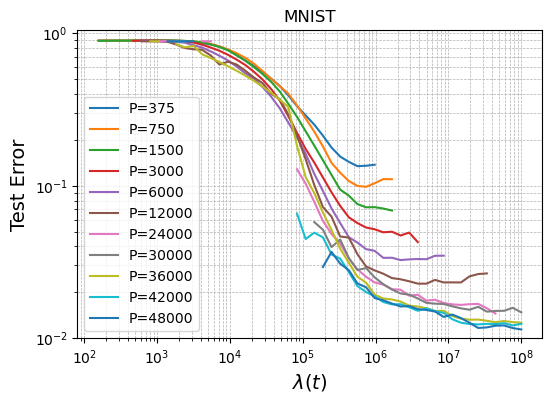

In [5]:
dataset = "MNIST"
P_arr = np.array([375, 750, 1500, 3000, 6000, 12000, 24000, 30000, 36000, 42000, 48000]) 
seed_arr = np.arange(100, 131, 1)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2.2, 8., num=50)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.05.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.01,1.05))
plt.show()

/tmp/ipykernel_240821/1670564542.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


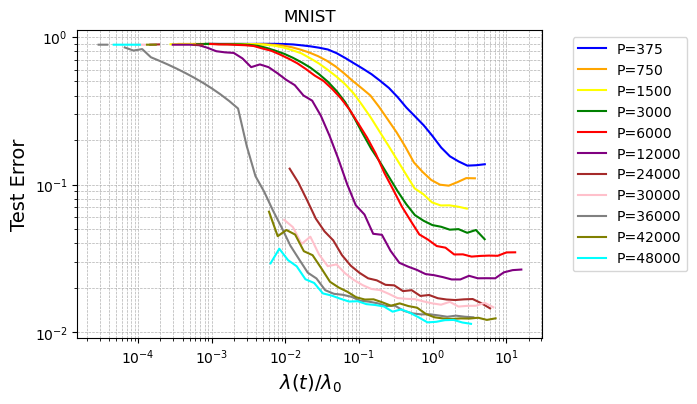

In [6]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.05.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_240821/3746842392.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


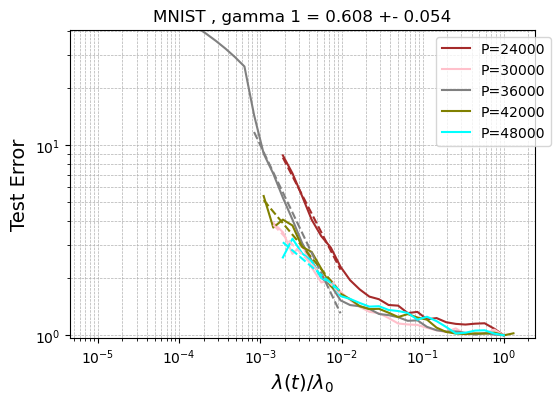

In [8]:
# Store interpolated results here
min_P = 6
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.05.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")


x_left = 7e-4
x_right = 1e-2
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,40.5))
plt.show()

Fitted power law: k2 = 327.3, gamma2 = 1.011


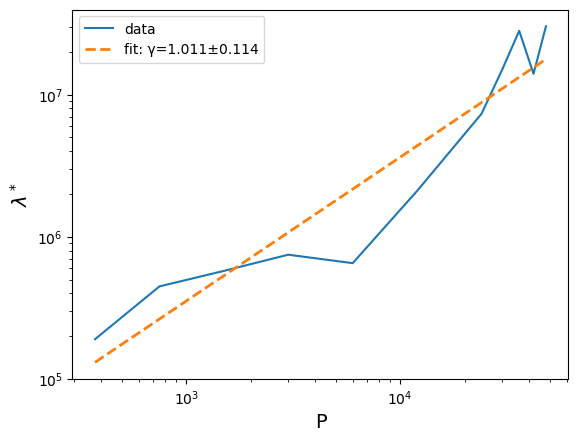

In [12]:
l_power_law = l_0_arr[:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

Predicted gamma =  0.6149581778276819


/tmp/ipykernel_240821/2755728690.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


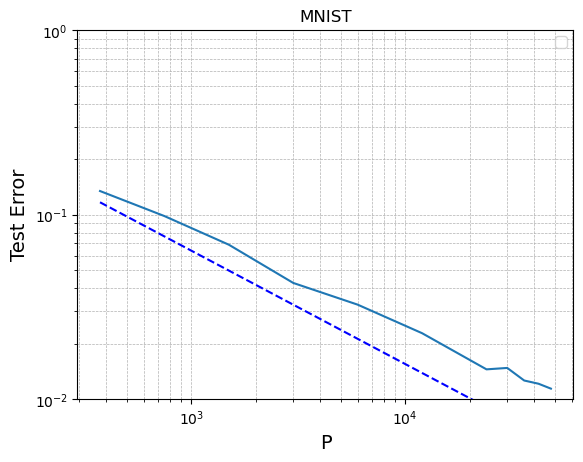

In [13]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

print("Predicted gamma = ", gamma_1*gamma_2)
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 1000*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

## ResNet

/tmp/ipykernel_240821/3784598887.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


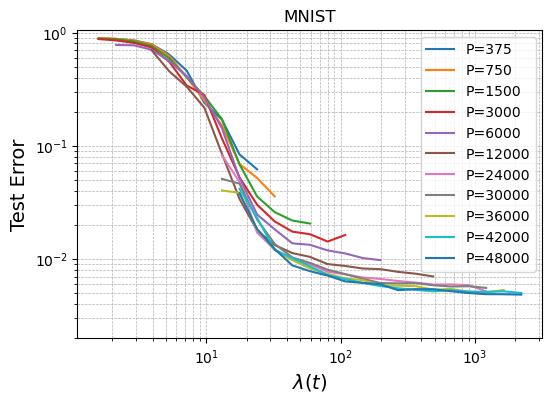

In [86]:
dataset = "MNIST"
P_arr = np.array([375, 750, 1500, 3000, 6000, 12000, 24000, 30000, 36000, 42000, 48000]) 
seed_arr = np.arange(100, 127, 1)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.2, 4, num=30)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.002,1.05))
plt.show()

/tmp/ipykernel_240821/464064301.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


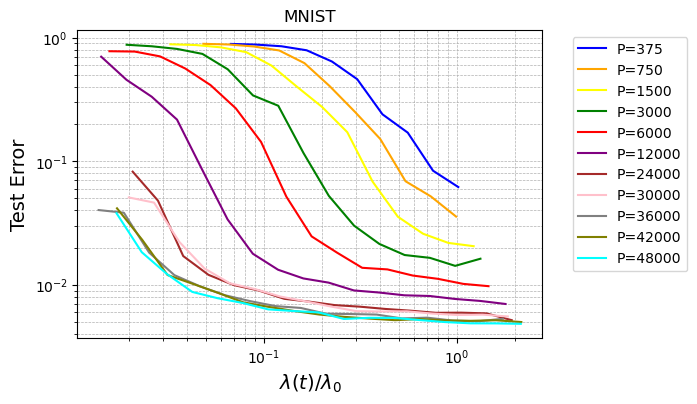

In [87]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_240821/9076325.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


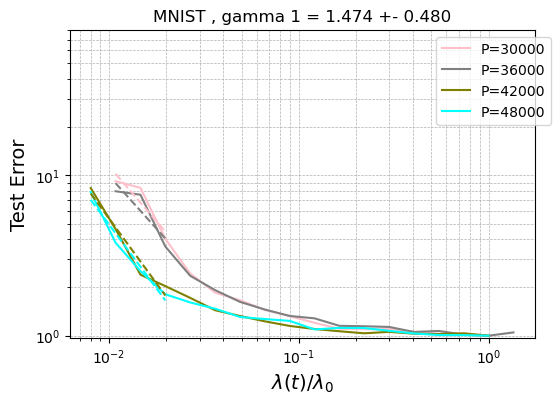

In [93]:
# Store interpolated results here
min_P = 7
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")


x_left = 0.8e-4
x_right = 2.e-2
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,80.5))
plt.show()

Fitted power law: k2 = 0.1228, gamma2 = 0.8359


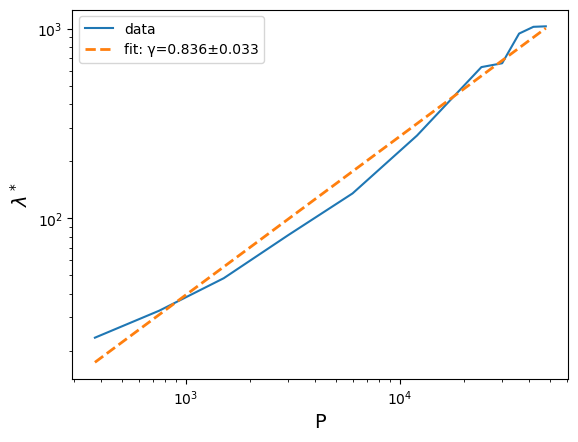

In [94]:
l_power_law = l_0_arr[:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr[:], l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

Predicted gamma =  1.2318586293979163


/tmp/ipykernel_240821/1150390920.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


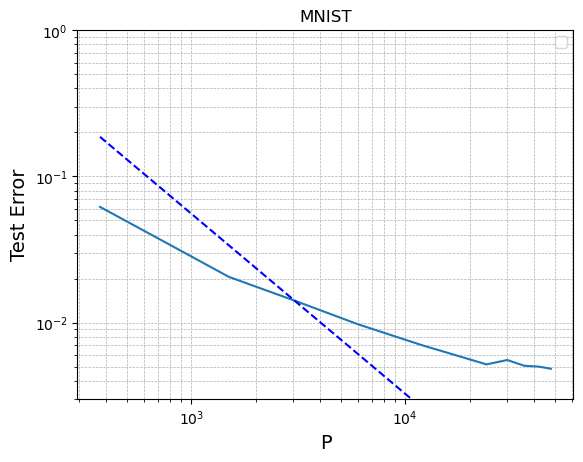

In [95]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

print("Predicted gamma = ", gamma_1*gamma_2)
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 1000*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((3e-3,1.01))
plt.show()

## ViT

/tmp/ipykernel_240821/2488466909.py:36: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


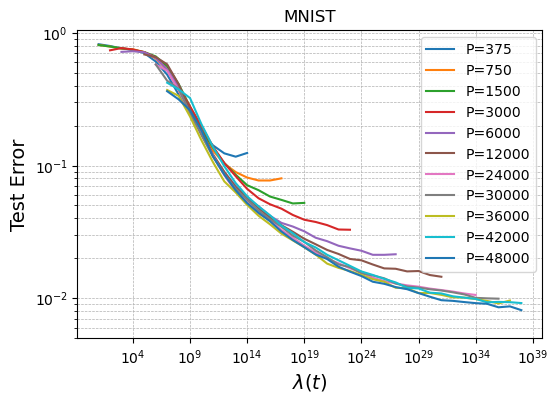

In [70]:
dataset = "MNIST"
P_arr = np.array([375, 750, 1500, 3000, 6000, 12000, 24000, 30000, 36000, 42000, 48000]) 
seed_arr = np.arange(100, 117, 1)

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(1, 40, num=40)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]))
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.005,1.05))
plt.show()

/tmp/ipykernel_240821/2071281081.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


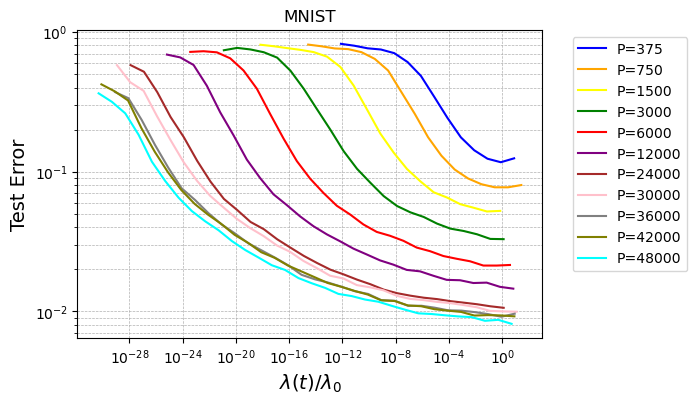

In [71]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]))
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_240821/2601542720.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


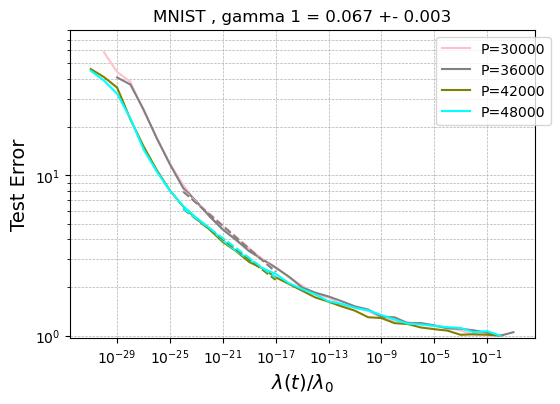

In [72]:
# Store interpolated results here
min_P = 7
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD0.0_INIT0.005.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]))
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")


x_left = 1e-24
x_right = 1e-17
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,80.5))
plt.show()

Fitted power law: k2 = 5.582e-19, gamma2 = 11.89


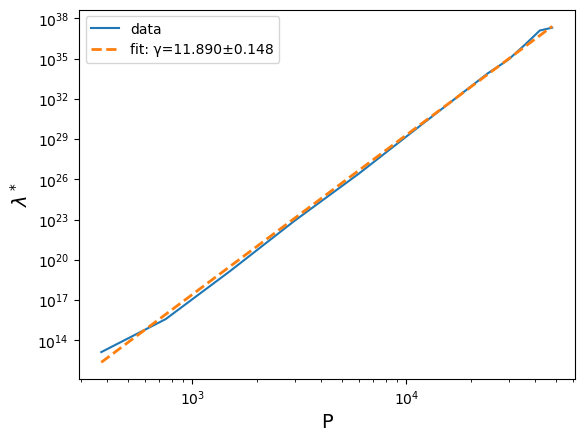

In [73]:
l_power_law = l_0_arr[:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

Predicted gamma =  0.7958364050824215


/tmp/ipykernel_240821/3859339137.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


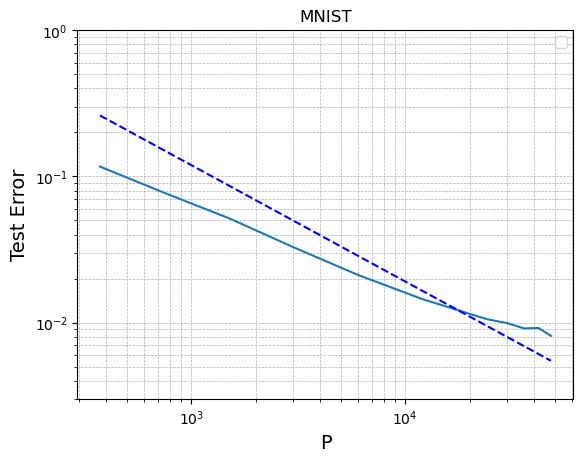

In [74]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

print("Predicted gamma = ", gamma_1*gamma_2)
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 10*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((3e-3,1.01))
plt.show()

# EARLY MNIST

In [34]:
dataset = "CIFAR10"
P_arr = np.arange(500, 5001, 500)
seed_arr = np.arange(10,15) 

colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2.2, 5.8, num=50)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.01,1.05))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../savings/CNN_CIFAR10_P500_seed10_WD0.0_EARLY.npy'

<Figure size 600x400 with 0 Axes>

In [ ]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [ ]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")


x_left = 1e-1
x_right = 7e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,40.5))
plt.show()

In [ ]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
print(gamma_1*gamma_2)

In [ ]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 1000000*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

#plt.ylim((1e-2,1.01))
plt.show()

## CNN

/tmp/ipykernel_30370/44144892.py:38: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


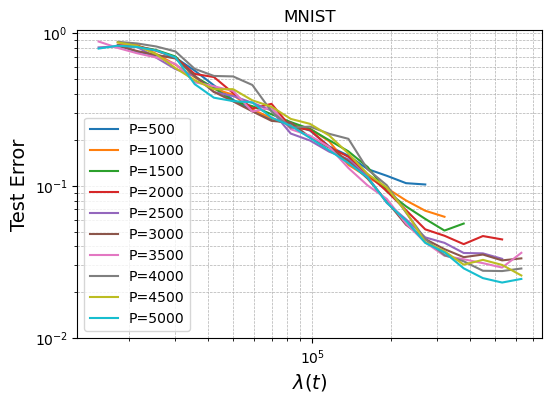

In [53]:
dataset = "MNIST"
P_arr = np.arange(500, 5001, 500)
seed_arr = np.arange(10,14) 


colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(2.2, 5.8, num=50)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))


to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD0.0_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.01,1.05))
plt.show()

/tmp/ipykernel_30370/2173204059.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


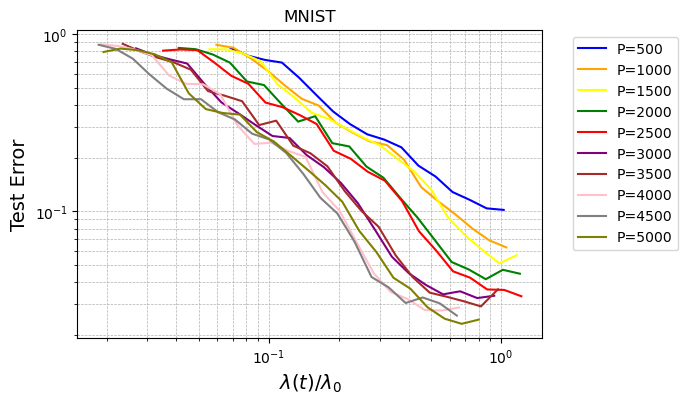

In [54]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_30370/2766255226.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


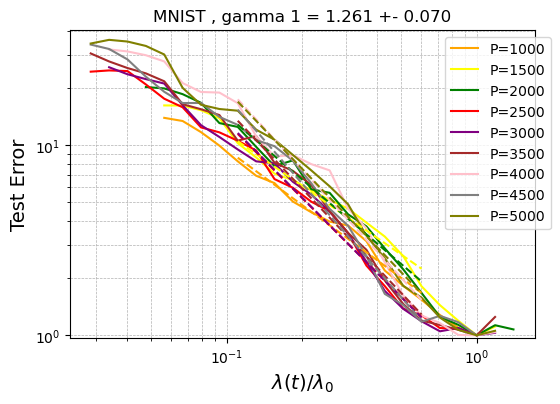

In [64]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")


x_left = 1e-1
x_right = 7e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,40.5))
plt.show()

Fitted power law: k2 = 1268, gamma2 = 0.7735


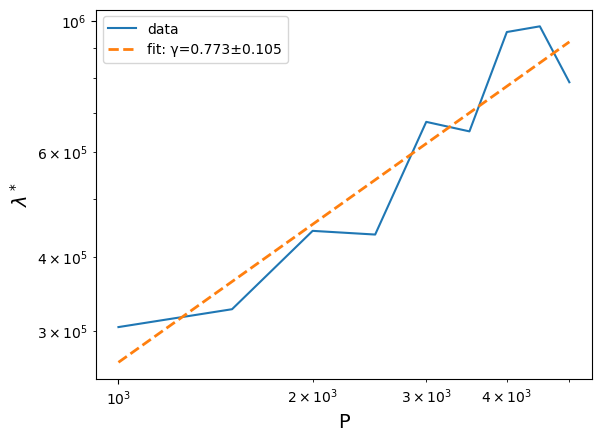

In [65]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [66]:
print(gamma_1*gamma_2)

0.9750212564518678


/tmp/ipykernel_30370/2656900854.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


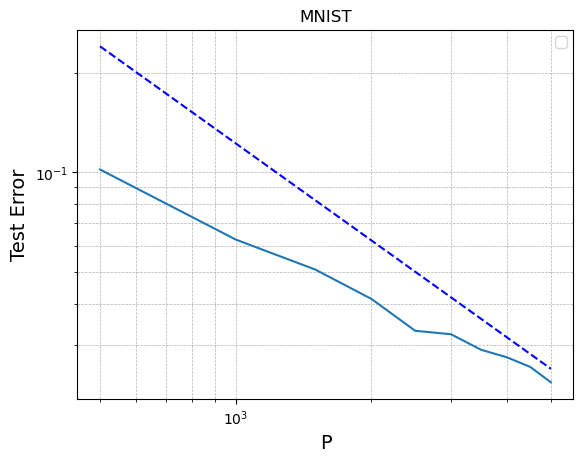

In [67]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 1000000*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

#plt.ylim((1e-2,1.01))
plt.show()

## ResNet

/tmp/ipykernel_30370/1753252187.py:38: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


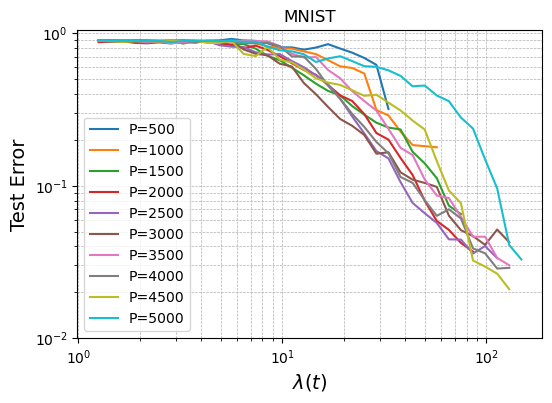

In [72]:
dataset = "MNIST"
P_arr = np.arange(500, 5001, 500)
seed_arr = np.arange(10,13) 


colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.1, 3, num=50)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))


to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD0.0_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.01,1.05))
plt.show()

/tmp/ipykernel_30370/1180966040.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


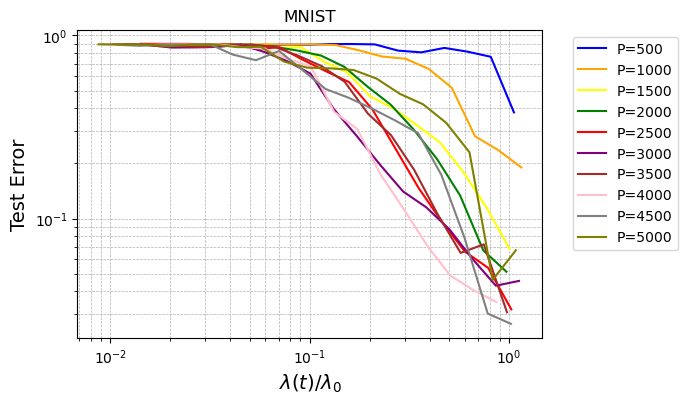

In [71]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ResNet_{dataset}_P{P}_seed{seed}_WD{wd}_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [ ]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/CNN_{dataset}_P{P}_seed{seed}_WD{wd}_EARLY.npy", allow_pickle=True).item()
        model_norm = np.array(logs_saved["model_norm"])
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 1e-1
x_right = 7e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,40.5))
plt.show()

In [ ]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

In [ ]:
print(gamma_1*gamma_2)

In [ ]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 1000000*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

#plt.ylim((1e-2,1.01))
plt.show()

## ViT

/tmp/ipykernel_54104/2641243928.py:38: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


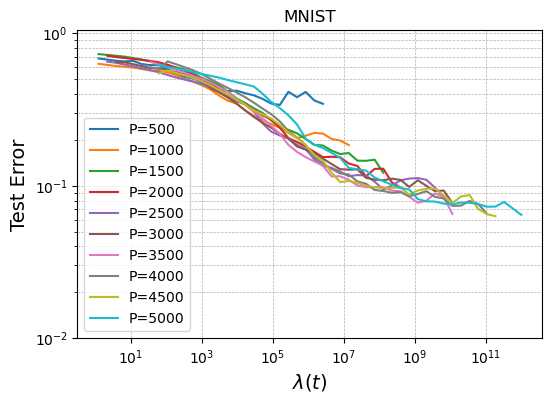

In [111]:
dataset = "MNIST"
P_arr = np.arange(500, 5001, 500)
seed_arr = np.arange(10,13) 


colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])
# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(0.1, 12, num=50)  # Adjust range and number of points as needed

# Store interpolated results here
mean_curves = {}
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))


to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid


plt.figure(figsize=(6,4))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD0.0_SCALED0.001.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]))
        val_error = np.array(logs_saved["val_error"])*0.01

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_val_error_arr[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error_arr[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.01,1.05))
plt.show()

/tmp/ipykernel_54104/1603130455.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


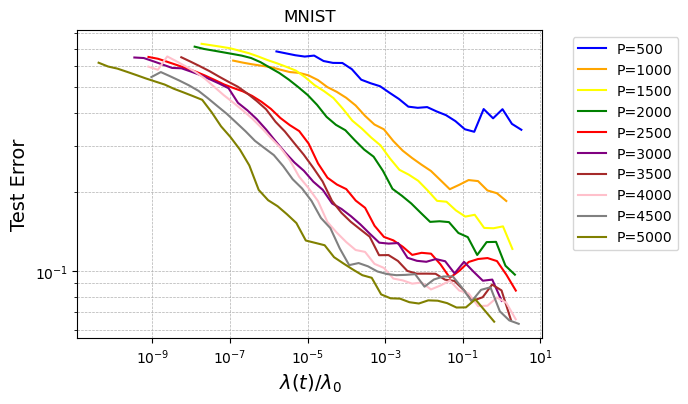

In [113]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = (np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD0.0_SCALED0.001.npy", allow_pickle=True).item())
        model_norm = np.exp(np.array(logs_saved["model_norm"]))
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_54104/2152942502.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


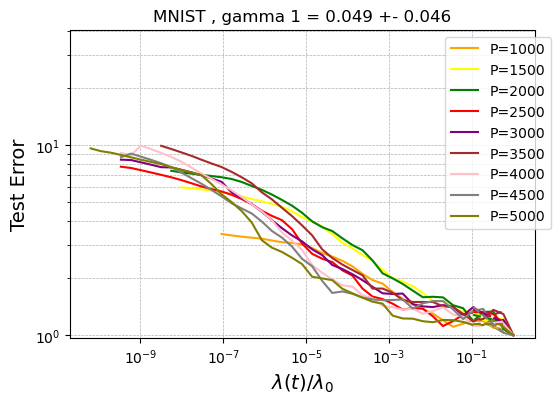

In [115]:
# Store interpolated results here
min_P = 1
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD0.0_SCALED0.001.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]))
        val_error = np.array(logs_saved["val_error"])*0.01
        train_error =np.array(logs_saved["train_error"])*0.01 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = 1e-1
x_right = 7e-1
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,40.5))
plt.show()

In [ ]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
print(gamma_1*gamma_2)

In [ ]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr, 1000000*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

#plt.ylim((1e-2,1.01))
plt.show()

# ViT new

## MNIST

/tmp/ipykernel_5201/2767289477.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


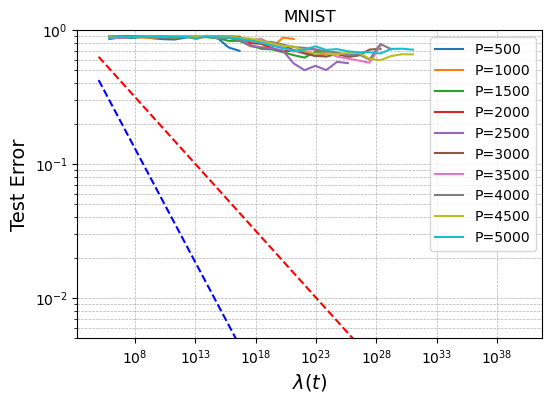

In [20]:
dataset = "MNIST"
P_arr = np.arange(500, 5001, 500)
seed_arr = np.arange(10,12)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(5, 40, num=40)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_EARLY.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")


gamma_1_a = 0.17
k1_a = 3
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = 0.1
k1_b = 2.
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.005,1.))
plt.show()


In [367]:
C2 = 1e3

/tmp/ipykernel_5204/1298629554.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


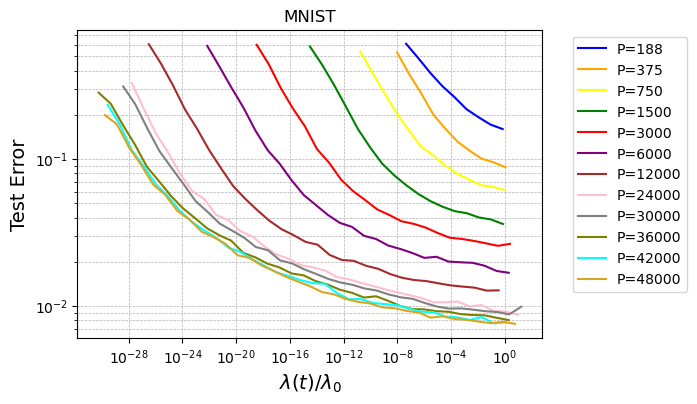

In [372]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_5204/1557866266.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


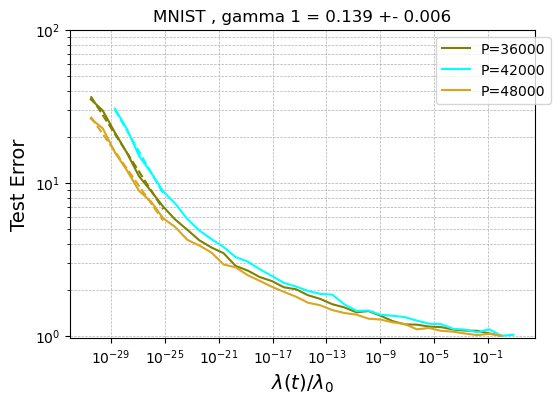

In [373]:
# Store interpolated results here
min_P = 9
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 1e-25
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,100.5))
plt.show()

In [374]:
factor = 1

Fitted power law: k2 = 3.025e+21, gamma2 = 3.411


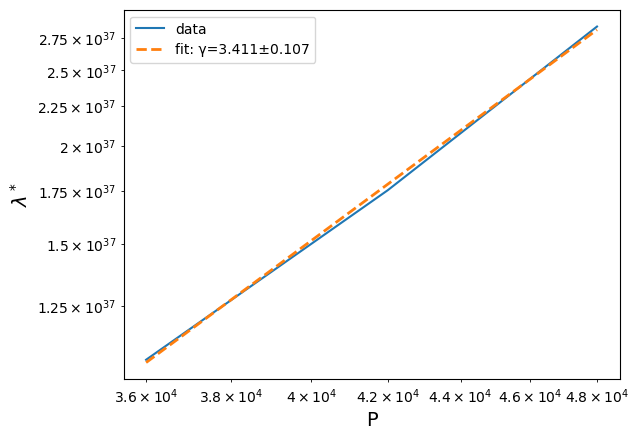

In [375]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2,err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

/tmp/ipykernel_5204/1672640404.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


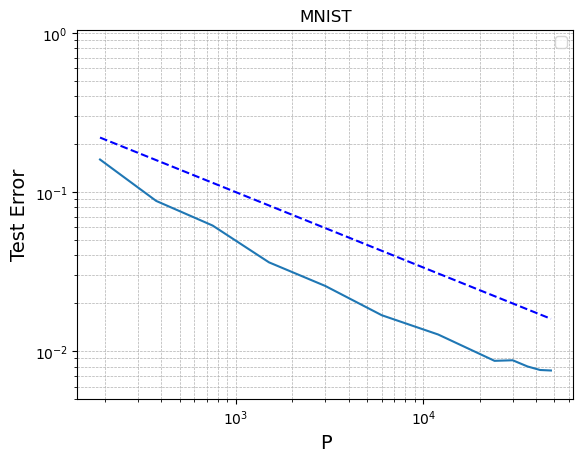

In [376]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]

plt.plot(P_arr, eps_lam_star_P_arr)

plt.plot(P_arr,  1000000*k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((5e-3,1.05))
plt.show()

In [377]:
name_save = "ViT_MNIST"


to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## CIFAR10 LONG

/tmp/ipykernel_10400/3053152669.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


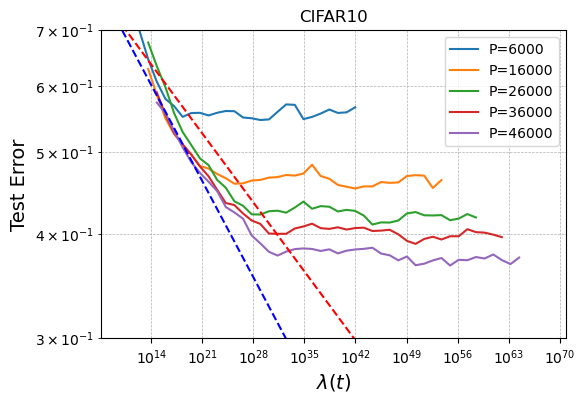

In [27]:
dataset = "CIFAR10"
P_arr = np.arange(6000, 46001, 10000)
seed_arr = np.arange(10,14)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(10, 68, num=50)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_28_07_LONG.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")

gamma_1_a = (1/61)
k1_a = 1.02
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = (1/85)
k1_b = 0.93
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.3,0.7))
plt.show()

In [11]:
C2 = 1e4

/tmp/ipykernel_10400/1115542363.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


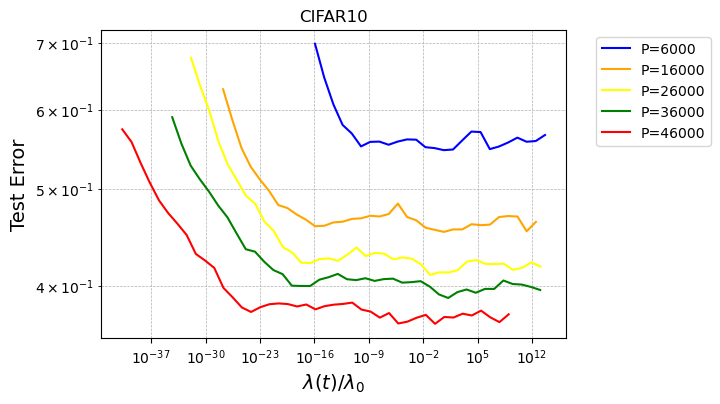

In [30]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_28_07_LONG.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr)*len(P_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_10400/2853190389.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


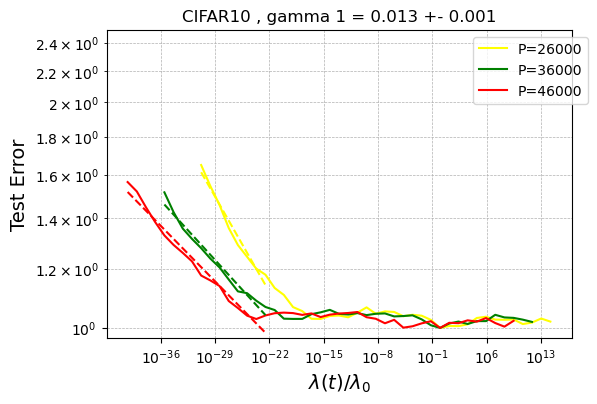

In [41]:
# Store interpolated results here
min_P = 2
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_28_07_LONG.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 1e-22
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.97,2.5))
plt.show()

Fitted power law: k2 = 6.32e-131, gamma2 = 39.64
0.5299740486852639


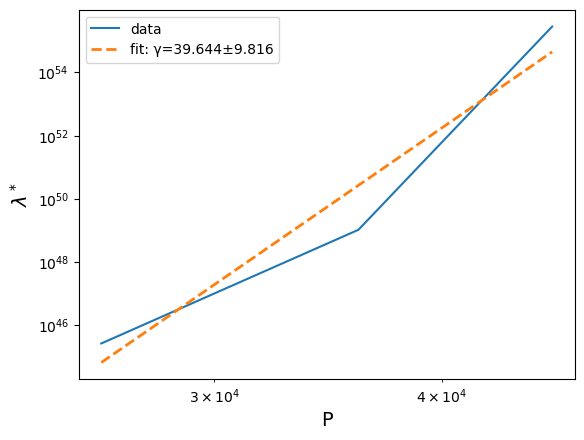

In [42]:
l_power_law = l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")
print(gamma_1*gamma_2)

In [10]:
'''
l_power_law = factor * l_0_arr

k2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)
print(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")
'''

'\nl_power_law = factor * l_0_arr\n\nk2, gamma_2 = fit_and_plot_powerlaw_offset(P_arr, l_power_law, C2)\nprint(f"Offset power law fit: k={k2:.4g}, γ={gamma_2:.4g}, C={C2:.4g}")\n'

[0.20335239 0.13506369 0.11029919 0.0962966  0.0869358 ]


/tmp/ipykernel_10400/3698693530.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


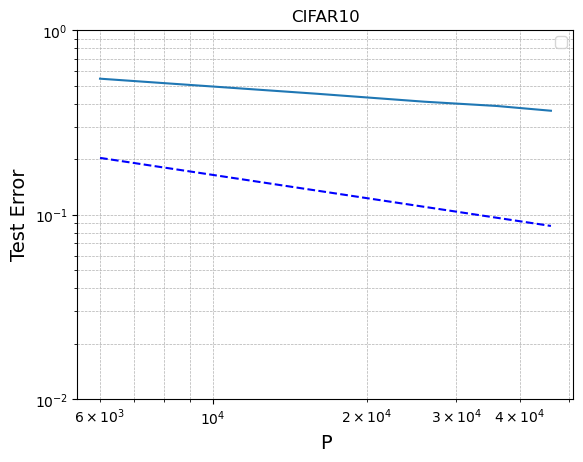

In [37]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

print(k1*(k2*P_arr**gamma_2)**-gamma_1)
plt.plot(P_arr, k1*(k2*P_arr**gamma_2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

In [406]:
name_save = "ViT_CIFAR10"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)

## Cifar100

/tmp/ipykernel_7679/1221537425.py:37: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


FileNotFoundError: [Errno 2] No such file or directory: '../../savings/ViT_CIFAR100_P46000_seed11_WD0.0_LONG.npy'

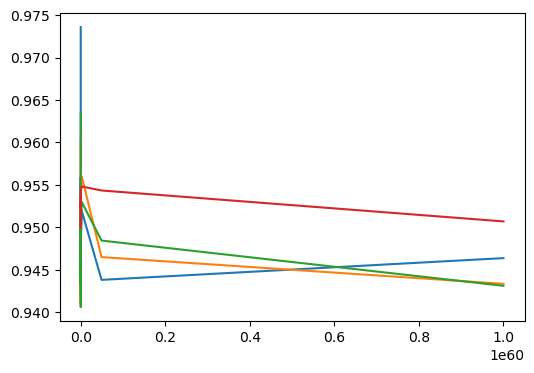

In [159]:
dataset = "CIFAR100"
P_arr = np.arange(6000, 46001, 10000)
seed_arr = np.arange(10,12)

wd=0.0
colorlist   = np.array(["blue","orange", "yellow","green","red","purple","brown","pink","grey","olive","cyan","goldenrod","palegreen"])

# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation
log_x_grid = np.logspace(9, 60, num=40)  # Adjust range and number of points as needed
mean_val_error_arr = np.zeros((len(P_arr), len(log_x_grid)))

to_save = {}
to_save["P_arr"] = P_arr
to_save["seed_arr"] = seed_arr
to_save["log_x_grid"] = log_x_grid

plt.figure(figsize=(6,4))

for i_P,P in enumerate(P_arr):
    interpolated_val_errors = []
    
    for seed in seed_arr:
        logs_saved = np.load(f"../../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}_LONG.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[P] = mean_val_error
    mean_val_error_arr[i_P] = mean_val_error


    # Plot the mean curve
    plt.plot(log_x_grid, mean_val_error, label=f"P={P}")


gamma_1_a = (1/135)
k1_a = 1.2
plt.plot(log_x_grid, k1_a*log_x_grid**-gamma_1_a, "--", color="blue")
gamma_1_b = (1/150)
k1_b = 1.19
plt.plot(log_x_grid, k1_b*log_x_grid**-gamma_1_b, "--", color="red")

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((0.6,1.))
plt.show()

In [15]:
C2 = 1e20

/tmp/ipykernel_32690/1298629554.py:32: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


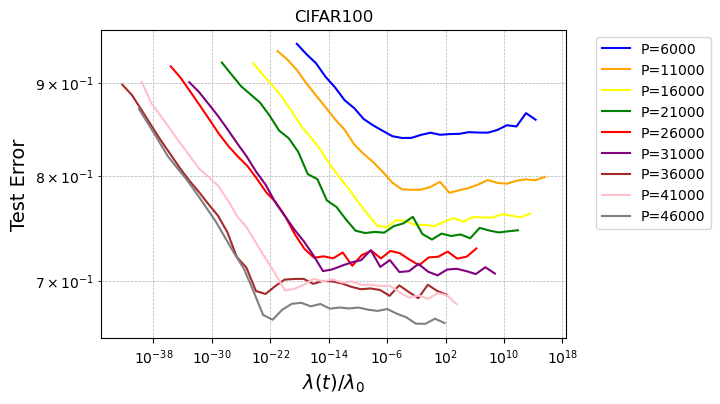

In [16]:
wd=0.0
# Store interpolated results here
mean_curves = {}

# Generate a common log-space grid for interpolation

plt.figure(figsize=(6,4))
l_0_arr = np.zeros(len(P_arr))

for i_P, P in enumerate(P_arr):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)

        idx_zero  = np.argmin((val_error)**2)
        where_zero = model_norm[idx_zero]
        w_z += where_zero/(len(seed_arr))

    interpolated_val_errors = np.array(interpolated_val_errors)
    
    # Compute mean ignoring NaNs (important if interpolation goes out of original data range)
    l_0_arr[i_P] = w_z
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)
    mean_curves[i_P] = mean_val_error

    # Plot the mean curve
    plt.plot(log_x_grid/w_z, mean_val_error,
             color=colorlist[i_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])
    

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

/tmp/ipykernel_32690/3081834397.py:28: RuntimeWarning: Mean of empty slice
  mean_val_error = np.nanmean(interpolated_val_errors, axis=0)


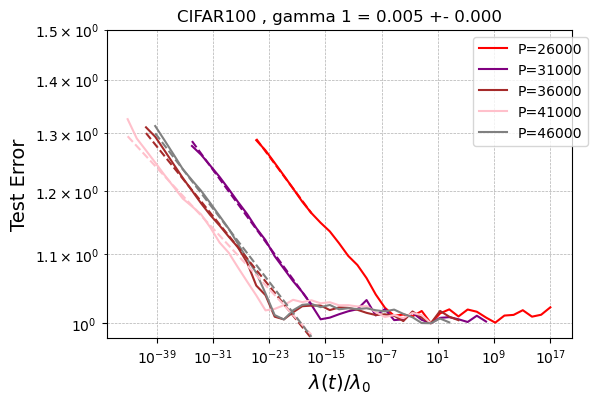

In [26]:
# Store interpolated results here
min_P = 4
P_arr_fit = P_arr[min_P:]

mean_curves = {}

plt.figure(figsize=(6,4))

wd=0.0

for i_P, P in enumerate(P_arr_fit):
    interpolated_val_errors = []
    w_z = 0
    
    for seed in seed_arr:
        logs_saved = np.load(f"../savings/ViT_{dataset}_P{P}_seed{seed}_WD{wd}.npy", allow_pickle=True).item()
        model_norm = np.exp(np.array(logs_saved["model_norm"]).astype(np.double))
        val_error = (np.array(logs_saved["val_error"])*0.01).astype(np.double)
        train_error =(np.array(logs_saved["train_error"])*0.01).astype(np.double) 

        # Interpolation: flat in log-scale, thus interpolate on log(x)
        interp_val_error = np.interp(np.log10(log_x_grid), np.log10(model_norm), val_error, left=np.nan, right=np.nan)
        interpolated_val_errors.append(interp_val_error)


    interpolated_val_errors = np.array(interpolated_val_errors)
    
    mean_val_error = np.nanmean(interpolated_val_errors, axis=0)

    idx = np.nanargmin(mean_val_error)
    # Plot the mean curve
    plt.plot(log_x_grid/log_x_grid[idx], mean_val_error/mean_val_error[idx],
             color=colorlist[i_P+min_P], label=f"P={P}")
    #plt.plot(log_x_grid, log_x_grid**-0.5, "-.",color="black")
    #plt.plot([w_z,w_z],  np.array([0.05,1.]), "--",
    #         color=colorlist[i_P])

    #gamma_1 = 0.23
    #k1 = 0.8
    #plt.plot(log_x_grid/log_x_grid[idx], k1*(log_x_grid/log_x_grid[idx])**-gamma_1, "--",
    #         color="black")

x_left = None
x_right = 1e-16
gamma_1, k1, err_gamma_1 = fit_phi(log_x_grid, mean_val_error_arr, P_arr_fit, min_P, x_left, x_right)

plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$\lambda(t)/\lambda_0$", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title("{} , gamma 1 = {:.3f} +- {:.3f}".format(dataset, gamma_1, err_gamma_1))
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.ylim((0.98,1.5))
plt.show()

In [24]:
factor = 1

Fitted power law: k2 = 4.629e-127, gamma2 = 39.69


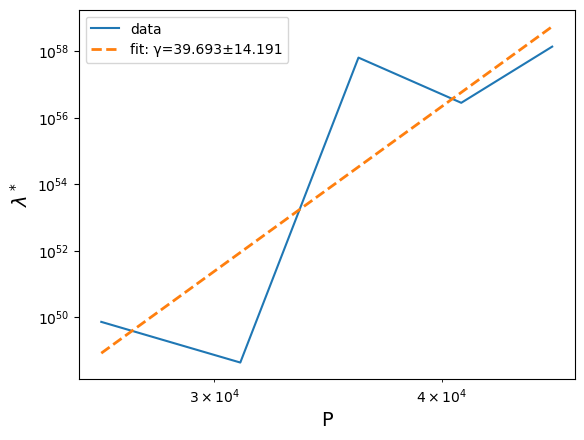

In [27]:
l_power_law = factor*l_0_arr[min_P:]
k2, gamma_2, err_gamma_2 = fit_and_plot_powerlaw(P_arr_fit, l_power_law)
print(f"Fitted power law: k2 = {k2:.4g}, gamma2 = {gamma_2:.4g}")

[0.62247539 0.54733152 0.50549017 0.47714123 0.45599548 0.43928628
 0.42556352 0.41397738 0.40398941]


/tmp/ipykernel_32690/2479446381.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


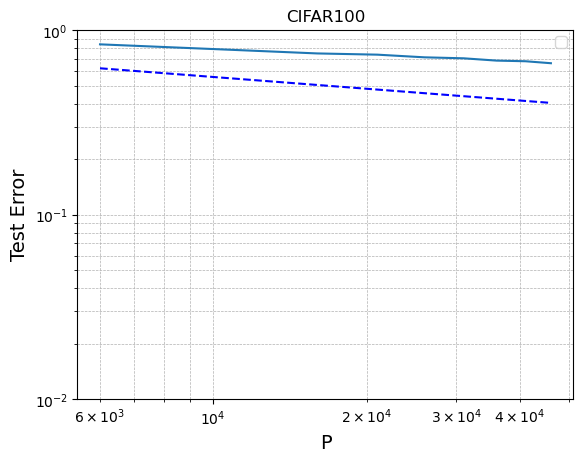

In [28]:
eps_lam_star_P_arr = np.zeros(len(P_arr))

lambda_star_arr = np.zeros(len(P_arr))

for i_P,P in enumerate(P_arr):
     idx = np.nanargmin(mean_val_error_arr[i_P])
     #idx = ((log_x_grid-l_power_law[i_P])**2) 
     eps_lam_star_P_arr[i_P] = mean_val_error_arr[i_P,idx]
     lambda_star_arr[i_P] = log_x_grid[idx]
    
plt.plot(P_arr, eps_lam_star_P_arr)

print(k1*(k2*P_arr**gamma_2-C2)**-gamma_1)
plt.plot(P_arr, k1*(k2*P_arr**gamma_2-C2)**-gamma_1, "--", color="blue")
#plt.plot(P_arr, 3.6*P_arr**-0.24, "--", color="red")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"P", fontsize=14)
plt.ylabel("Test Error", fontsize=14)
plt.legend()
plt.title(dataset)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.ylim((1e-2,1.01))
plt.show()

In [29]:
name_save = "ViT_CIFAR100"

to_save["mean_val_error_arr"] = mean_val_error_arr
to_save["eps_lam_star_P_arr"] = eps_lam_star_P_arr
to_save["lambda_star_arr"] = lambda_star_arr
to_save["k1"] = k1
to_save["gamma_1"] = gamma_1
to_save["err_gamma_1"] = err_gamma_1
to_save["k2"] = k2
to_save["gamma_2"] = gamma_2
to_save["err_gamma_2"] = err_gamma_2
to_save["C2"] = C2
to_save["factor"] = factor
to_save["l_0_arr"] = l_0_arr
to_save["min_P"] = min_P

np.save(name_save, to_save)